In [1]:
import itertools

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from typing import Tuple
from multiprocessing import Pool
import math
rng = np.random.default_rng(12345)

In [2]:
CONTROL_TIMESTEP_DAYS = 10
NUM_CONTROL_STEPS = 4
# corn prices are measured in USD / 56 lbs at 15.5% moisture (by mass)
CORN_PRICE_USD_PER_G_GRAIN = 4.80 / (1 - 0.155) / 25401.2
N_PRICE_USD_PER_G = 0.0011
N_SUFFICIENT_YIELD_G_GRAIN_PER_M2 = 1200
NNI_TO_RELATIVE_YIELD_CORRELATION = 1.17
MAX_BIOMASS_G_DRY_MASS_PER_M2 = 3000

INORGANIC_N_MODEL_DT_DAYS = 1.0 / 24.0 * 2.0 / 6.0

NUM_DAYS_TOTAL = CONTROL_TIMESTEP_DAYS * NUM_CONTROL_STEPS
SOIL_POROSITY = 0.35 # Porporato had 0.4
SOIL_DEPTH_MM = 300 # Porporato had 800
SOIL_VOID_SPACE_MM = SOIL_POROSITY * SOIL_DEPTH_MM
HYGROSCOPIC_POINT = 0.04 # Porporato had 0.02
WILTING_POINT = 0.05 # Porporato had 0.065
MAX_MOISTURE_WITH_CLOSED_STOMATA = 0.16 # Porporato had 0.17
FIELD_CAPACITY = 0.35 # Porporato had 0.3
MAXIMUM_EVAPORATION_RATE_MM_PER_DAY = 0.1 # Porporato had 1.0
MAXIMUM_TRANSPIRATION_RATE_MM_PER_DAY = 3.6 # Porporato had 3.5
SATURATED_HYDRAULIC_CONDUCTIVITY_MM_PER_DAY = 1000 # Porporato had 1100
PORE_SIZE_DISTRIBUTION_INDEX = 4.05 # 4.05 for porporato conditions
BETA = 4.0 * PORE_SIZE_DISTRIBUTION_INDEX + 4.0
ADDED_RESIDUE_CARBON_G_PER_M2_PER_DAY = 1.5
PROPORTION_BIOMASS_DYING_PER_DAY = 0.0085
PROPORTION_LITTER_DECOMPOSING_PER_BIOMASS_PER_DAY = 0.000065
PROPORTION_HUMUS_DECOMPOSING_PER_BIOMASS_PER_DAY = 0.0000025
MAX_PROPORTION_AMMONIUM_IMMOBILIZED_PER_DAY = 1.0
MAX_PROPORTION_NITRATE_IMMOBILIZED_PER_DAY = 1.0
PROPORTION_AMMONIUM_NITRIFIED_PER_BIOMASS_PER_DAY = 0.006 # porporato had 0.6
DISSOLVED_FRACTION_AMMONIUM = 0.05
DISSOLVED_FRACTION_NITRATE = 1.0 # https://link.springer.com/chapter/10.1007/978-94-007-0394-0_23/tables/4 has 0.1 but that can't be right
RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON = 0.6
NON_RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON = 1 - RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON
MAX_HUMIFIED_FRACTION_OF_DECOMPOSED_LITTER = 0.25
ADDED_RESIDUE_CN_RATIO = 58
BIOMASS_CN_RATIO = 11.5
HUMUS_CN_RATIO = 22 # porporato had 22
EXCESS_BIO_NITROGEN_PER_HUMUS_CARBON_DECOMPOSED = 1 / HUMUS_CN_RATIO - NON_RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON / BIOMASS_CN_RATIO
# PLANT_AMMONIUM_DEMAND_GRAMS_N_PER_M3_PER_DAY = 0.2
# PLANT_NITRATE_DEMAND_GRAMS_N_PER_M3_PER_DAY = 0.5
PLANT_BIOMASS_G_DRY_MASS_PER_M2 = 600 # roughly 17L stage
DIFFUSION_COEFFICIENT_MM_PER_DAY = 100 # possibly should be 100 ? Porporato has 0.1 meters/day
DIFFUSION_MOISTURE_DEPENDENCE_EXPONENT = 1.5 # Porporato had 3
RAIN_EXISTENCE_RATE = 0.3 # porporato had 0.23
RAIN_MEAN_DEPTH_MM = 15.5 # porporato had 11

In [67]:
f_d = np.vectorize(lambda s : s / FIELD_CAPACITY if s <= FIELD_CAPACITY else FIELD_CAPACITY / s)
f_n = np.vectorize(lambda s: s / FIELD_CAPACITY if s <= FIELD_CAPACITY else (1 - s)/(1- FIELD_CAPACITY))
# N_c (g/kg DM) = 3.40 * (W (Mg DM / ha))^-0.37
# N_c (g/ha) = 3.40 * (W (Mg DM/ha)) ^ (1 - 0.37)
biomass_g_per_m2_to_critical_nitrogen_gN_per_m2 = np.vectorize(lambda w: 0.187 * (w ** 0.63))
day_to_biomass_g_per_m2 = np.vectorize(lambda day: day / NUM_DAYS_TOTAL * MAX_BIOMASS_G_DRY_MASS_PER_M2 + 0.001)
day_to_plant_N_demand_gN_per_m3_per_day = np.vectorize(lambda day: 2.5) #TODO make time-varying

In [47]:
print("N sufficient corn yield, in USD/m^2:", N_SUFFICIENT_YIELD_G_GRAIN_PER_M2 * CORN_PRICE_USD_PER_G_GRAIN)

N sufficient corn yield, in USD/m^2: 0.26835614251835654


# Water Modeling

In [4]:
def generate_rain(num_days: int):
    rain_events = rng.random(num_days) < RAIN_EXISTENCE_RATE
    rain_quantity_mm = rng.exponential(RAIN_MEAN_DEPTH_MM, num_days) * rain_events
    return rain_quantity_mm

def hydrology_model(initial_soil_moisture: float, rain_quantity_mm: npt.NDArray[np.float64]):
    num_days = len(rain_quantity_mm)

    # Define constants for computational efficiency
    LEAKAGE_COEFF = SATURATED_HYDRAULIC_CONDUCTIVITY_MM_PER_DAY / (np.exp(BETA * (1 - FIELD_CAPACITY)) - 1)
    TRANSPIRATION_SLOPE = MAXIMUM_TRANSPIRATION_RATE_MM_PER_DAY / (MAX_MOISTURE_WITH_CLOSED_STOMATA - WILTING_POINT)

    # States and intermediate variables
    soil_moisture = np.zeros(num_days)
    infiltration_rate_mm_per_day = np.zeros(num_days)
    evaporation_rate_mm_per_day = np.zeros(num_days)
    transpiration_rate_mm_per_day = np.zeros(num_days)
    leakage_rate_mm_per_day = np.zeros(num_days)

    soil_moisture[0] = initial_soil_moisture

    for i in range(num_days):
        infiltration_rate_mm_per_day[i] = min(rain_quantity_mm[i], SOIL_VOID_SPACE_MM * (1 - soil_moisture[i]))

        # evaporation
        if soil_moisture[i] < HYGROSCOPIC_POINT:
            evaporation_rate_mm_per_day[i] = 0
        elif soil_moisture[i] <= WILTING_POINT:
            evaporation_rate_mm_per_day[i] = MAXIMUM_EVAPORATION_RATE_MM_PER_DAY * (soil_moisture[i] - HYGROSCOPIC_POINT)
        else:
            evaporation_rate_mm_per_day[i] = MAXIMUM_EVAPORATION_RATE_MM_PER_DAY

        # Transpiration
        if soil_moisture[i] <= WILTING_POINT:
            transpiration_rate_mm_per_day[i] = 0
        elif soil_moisture[i] <= MAX_MOISTURE_WITH_CLOSED_STOMATA:
            transpiration_rate_mm_per_day[i] = TRANSPIRATION_SLOPE * (soil_moisture[i] - WILTING_POINT)
        else:
            transpiration_rate_mm_per_day[i] = MAXIMUM_TRANSPIRATION_RATE_MM_PER_DAY

        # leakage/percolation
        leakage_rate_mm_per_day[i] = LEAKAGE_COEFF * (np.exp(BETA * (soil_moisture[i] - FIELD_CAPACITY)) - 1)
        if soil_moisture[i] - (leakage_rate_mm_per_day[i] / SOIL_VOID_SPACE_MM) < FIELD_CAPACITY: # make sure we don't drain more than is possible in very wet fields
            leakage_rate_mm_per_day[i] = max(0, (soil_moisture[i] - FIELD_CAPACITY) * SOIL_VOID_SPACE_MM)

        if i + 1 < num_days:
            soil_moisture[i+1] = soil_moisture[i] + (infiltration_rate_mm_per_day[i] - evaporation_rate_mm_per_day[i] - transpiration_rate_mm_per_day[i] - leakage_rate_mm_per_day[i]) / SOIL_VOID_SPACE_MM

    moisture_effect_on_decomposition_factor = f_d(soil_moisture)
    moisture_effect_on_nitrification_factor = f_n(soil_moisture)

    if any(infiltration_rate_mm_per_day < 0) or any(evaporation_rate_mm_per_day < 0) or any(transpiration_rate_mm_per_day < 0) or any(leakage_rate_mm_per_day < 0) or any(soil_moisture < 0) or any(soil_moisture > 1) or any(moisture_effect_on_decomposition_factor < 0) or any(moisture_effect_on_decomposition_factor > 1) or any(moisture_effect_on_nitrification_factor < 0) or any(moisture_effect_on_nitrification_factor > 1):
        print("Sanity check failed in hydrology model!")

    return soil_moisture, infiltration_rate_mm_per_day, evaporation_rate_mm_per_day, transpiration_rate_mm_per_day, leakage_rate_mm_per_day, moisture_effect_on_decomposition_factor, moisture_effect_on_nitrification_factor


# Soil Organic Matter Model

In [5]:
def soil_organic_model(initial_litter_carbon_gC_per_m3: float, initial_litter_nitrogen_gN_per_m3: float, initial_microbial_carbon_gC_per_m3: float, initial_humus_carbon_gC_per_m3: float, moisture_decomposition_factor: npt.NDArray[np.float64], added_residue_nitrogen_gN_per_m3_per_day: npt.NDArray[np.float64], added_residue_carbon_gC_per_m3_per_day: npt.NDArray[np.float64]):
    array_length = len(moisture_decomposition_factor)
    assert len(added_residue_nitrogen_gN_per_m3_per_day) == array_length
    assert len(added_residue_carbon_gC_per_m3_per_day) == array_length

    # Set up arrays
    litter_cn_ratio_gC_per_gN = np.ndarray(array_length, np.float64)
    humified_fraction_of_decomposed_litter_carbon = np.ndarray(array_length, np.float64)
    microbified_fraction_of_decomposed_litter_carbon = np.ndarray(array_length, np.float64)
    litter_decomposition_carbon_gC_per_m3_per_day = np.ndarray(array_length, np.float64)
    humus_decomposition_carbon_gC_per_m3_per_day = np.ndarray(array_length, np.float64)
    microbial_death_carbon_gC_per_m3_per_day = np.ndarray(array_length, np.float64)
    litter_carbon_gC_per_m3 = np.ndarray(array_length, np.float64)
    litter_nitrogen_gN_per_m3 = np.ndarray(array_length, np.float64)
    microbial_carbon_gC_per_m3 = np.ndarray(array_length, np.float64)
    humus_carbon_gC_per_m3 = np.ndarray(array_length, np.float64)

    # Assign initial values
    litter_carbon_gC_per_m3[0] = initial_litter_carbon_gC_per_m3
    litter_nitrogen_gN_per_m3[0] = initial_litter_nitrogen_gN_per_m3
    microbial_carbon_gC_per_m3[0] = initial_microbial_carbon_gC_per_m3
    humus_carbon_gC_per_m3[0] = initial_humus_carbon_gC_per_m3

    # Simulate
    for i in range(array_length):
        # intermediaries
        litter_cn_ratio_gC_per_gN[i] = litter_carbon_gC_per_m3[i] / litter_nitrogen_gN_per_m3[i]
        humified_fraction_of_decomposed_litter_carbon[i] = min(MAX_HUMIFIED_FRACTION_OF_DECOMPOSED_LITTER, HUMUS_CN_RATIO / litter_cn_ratio_gC_per_gN[i])
        microbified_fraction_of_decomposed_litter_carbon[i] = NON_RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON - humified_fraction_of_decomposed_litter_carbon[i]
        litter_decomposition_carbon_gC_per_m3_per_day[i] = PROPORTION_LITTER_DECOMPOSING_PER_BIOMASS_PER_DAY * moisture_decomposition_factor[i] * microbial_carbon_gC_per_m3[i] * litter_carbon_gC_per_m3[i]
        humus_decomposition_carbon_gC_per_m3_per_day[i] = PROPORTION_HUMUS_DECOMPOSING_PER_BIOMASS_PER_DAY * moisture_decomposition_factor[i] * microbial_carbon_gC_per_m3[i] * humus_carbon_gC_per_m3[i]
        microbial_death_carbon_gC_per_m3_per_day[i] = PROPORTION_BIOMASS_DYING_PER_DAY * microbial_carbon_gC_per_m3[i]

        # states
        if i + 1 < array_length:
            litter_carbon_gC_per_m3[i + 1] = litter_carbon_gC_per_m3[i] + added_residue_carbon_gC_per_m3_per_day[i] + microbial_death_carbon_gC_per_m3_per_day[i] - litter_decomposition_carbon_gC_per_m3_per_day[i]
            litter_nitrogen_gN_per_m3[i + 1] = litter_nitrogen_gN_per_m3[i] + added_residue_nitrogen_gN_per_m3_per_day[i] + (microbial_death_carbon_gC_per_m3_per_day[i] / BIOMASS_CN_RATIO) - (litter_decomposition_carbon_gC_per_m3_per_day[i] / litter_cn_ratio_gC_per_gN[i])
            microbial_carbon_gC_per_m3[i + 1] = microbial_carbon_gC_per_m3[i] + microbified_fraction_of_decomposed_litter_carbon[i] * litter_decomposition_carbon_gC_per_m3_per_day[i] + NON_RESPIRATED_FRACTION_OF_DECOMPOSED_CARBON * humus_decomposition_carbon_gC_per_m3_per_day[i] - microbial_death_carbon_gC_per_m3_per_day[i]
            humus_carbon_gC_per_m3[i + 1] = humus_carbon_gC_per_m3[i] + humified_fraction_of_decomposed_litter_carbon[i] * litter_decomposition_carbon_gC_per_m3_per_day[i] - humus_decomposition_carbon_gC_per_m3_per_day[i]

        # External flows
    excess_bio_nitrogen_per_litter_carbon_decomposed_gN_per_gC = 1 / litter_cn_ratio_gC_per_gN - humified_fraction_of_decomposed_litter_carbon / HUMUS_CN_RATIO - microbified_fraction_of_decomposed_litter_carbon / BIOMASS_CN_RATIO
    net_flux_to_mineral_nitrogen_gN_per_m3_per_day = EXCESS_BIO_NITROGEN_PER_HUMUS_CARBON_DECOMPOSED * humus_decomposition_carbon_gC_per_m3_per_day + excess_bio_nitrogen_per_litter_carbon_decomposed_gN_per_gC * litter_decomposition_carbon_gC_per_m3_per_day

    if any(humified_fraction_of_decomposed_litter_carbon < 0) or any(microbified_fraction_of_decomposed_litter_carbon < 0) or any(litter_decomposition_carbon_gC_per_m3_per_day < 0) or any(humus_decomposition_carbon_gC_per_m3_per_day < 0) or any(microbial_carbon_gC_per_m3 < 0) or any(microbial_carbon_gC_per_m3 > 500) or any(litter_carbon_gC_per_m3 < 0) or any(litter_carbon_gC_per_m3 > 10000) or any(litter_nitrogen_gN_per_m3 < 0) or any(litter_nitrogen_gN_per_m3 > 500) or any(microbial_carbon_gC_per_m3 < 0) or any(microbial_carbon_gC_per_m3 > 500) or any(humus_carbon_gC_per_m3 < 0) or any(humus_carbon_gC_per_m3 > 100000):
        print("Sanity check failed in soil organic model!")

    return litter_carbon_gC_per_m3, litter_nitrogen_gN_per_m3, microbial_carbon_gC_per_m3, humus_carbon_gC_per_m3, net_flux_to_mineral_nitrogen_gN_per_m3_per_day

# Inorganic Nitrogen Model

In [6]:
def inorganic_nitrogen_model(initial_ammonium_gN_per_m3: float, initial_nitrate_gN_per_m3: float, initial_day: float, leakage_mm_per_day: npt.NDArray[np.float64], transpiration_mm_per_day: npt.NDArray[np.float64], soil_moisture: npt.NDArray[np.float64], net_flux_to_mineral_nitrogen_gN_per_m3_per_day: npt.NDArray[np.float64], microbial_carbon_gC_per_m3: npt.NDArray[np.float64], input_dt_days: float = 1.0, output_dt_days: float = INORGANIC_N_MODEL_DT_DAYS) -> Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64],npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.bool], npt.NDArray[np.float64]]:
    array_length = len(leakage_mm_per_day)
    assert len(transpiration_mm_per_day) == array_length
    assert len(soil_moisture) == array_length
    assert len(net_flux_to_mineral_nitrogen_gN_per_m3_per_day) == array_length
    assert len(microbial_carbon_gC_per_m3) == array_length

    # scaled arrays, for computational efficiency
    moisture_nitrification_factor = f_n(soil_moisture)
    moisture_decomposition_factor = f_d(soil_moisture)
    volume_water_per_unit_area_mm = soil_moisture * SOIL_DEPTH_MM * SOIL_POROSITY
    volume_water_per_unit_area_mm[volume_water_per_unit_area_mm == 0] = 0.01 # to avoid divide by zero
    nitrification_rate_constant = moisture_nitrification_factor * PROPORTION_AMMONIUM_NITRIFIED_PER_BIOMASS_PER_DAY * microbial_carbon_gC_per_m3
    ammonium_passive_uptake_rate_constant = DISSOLVED_FRACTION_AMMONIUM * transpiration_mm_per_day / volume_water_per_unit_area_mm
    ammonium_max_active_uptake_rate_constant = DISSOLVED_FRACTION_AMMONIUM * DIFFUSION_COEFFICIENT_MM_PER_DAY / volume_water_per_unit_area_mm * (soil_moisture ** DIFFUSION_MOISTURE_DEPENDENCE_EXPONENT)
    ammonium_leaching_rate_constant = DISSOLVED_FRACTION_AMMONIUM * leakage_mm_per_day / volume_water_per_unit_area_mm
    nitrate_passive_uptake_rate_constant = DISSOLVED_FRACTION_NITRATE * transpiration_mm_per_day / volume_water_per_unit_area_mm
    nitrate_max_active_uptake_rate_constant = DISSOLVED_FRACTION_NITRATE * DIFFUSION_COEFFICIENT_MM_PER_DAY / volume_water_per_unit_area_mm * (soil_moisture ** DIFFUSION_MOISTURE_DEPENDENCE_EXPONENT)
    nitrate_leaching_rate_constant = DISSOLVED_FRACTION_NITRATE * leakage_mm_per_day / volume_water_per_unit_area_mm
    # constants
    time_stretch = input_dt_days / output_dt_days
    output_array_length = int(array_length * time_stretch)
    # N demand
    absolute_day = np.linspace(initial_day, initial_day + array_length * input_dt_days, output_array_length)
    plant_N_demand_gN_per_m3_per_day = day_to_plant_N_demand_gN_per_m3_per_day(absolute_day)
    plant_ammonium_demand_gN_per_m3_per_day = plant_N_demand_gN_per_m3_per_day / 2.0
    plant_nitrate_demand_gN_per_m3_per_day = plant_N_demand_gN_per_m3_per_day / 2.0

    # Set up arrays
    available_nitrogen_for_immobilization_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    maximum_immobilization_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    nitrification_assumptions_violation = np.full(output_array_length, False, np.bool)
    nitrification_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    mineralization_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    total_immobilization_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    immobilization_from_ammonium_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    plant_passive_uptake_of_ammonium_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    maximum_active_ammonium_uptake_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    plant_active_uptake_of_ammonium_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    ammonium_leaching_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    immobilization_from_nitrate_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    plant_passive_uptake_of_nitrate_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    maximum_active_nitrate_uptake_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    plant_active_uptake_of_nitrate_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)
    nitrate_leaching_gN_per_m3_per_day = np.ndarray(output_array_length, np.float64)

    ammonium_gN_per_m3 = np.ndarray(output_array_length, np.float64)
    nitrate_gN_per_m3 = np.ndarray(output_array_length, np.float64)

    # Assign initial values
    ammonium_gN_per_m3[0] = initial_ammonium_gN_per_m3
    nitrate_gN_per_m3[0] = initial_nitrate_gN_per_m3

    # Simulate
    for i in range(output_array_length):
        input_index = int(i / time_stretch)
        available_nitrogen_for_immobilization_gN_per_m3_per_day[i] = MAX_PROPORTION_AMMONIUM_IMMOBILIZED_PER_DAY * ammonium_gN_per_m3[i] + MAX_PROPORTION_NITRATE_IMMOBILIZED_PER_DAY * nitrate_gN_per_m3[i]
        maximum_immobilization_gN_per_m3_per_day[i] = moisture_decomposition_factor[input_index] * available_nitrogen_for_immobilization_gN_per_m3_per_day[i]
        if net_flux_to_mineral_nitrogen_gN_per_m3_per_day[input_index] > 0:
            mineralization_gN_per_m3_per_day[i] = net_flux_to_mineral_nitrogen_gN_per_m3_per_day[input_index]
            total_immobilization_gN_per_m3_per_day[i] = 0
        else:
            mineralization_gN_per_m3_per_day[i] = 0
            total_immobilization_gN_per_m3_per_day[i] = -net_flux_to_mineral_nitrogen_gN_per_m3_per_day[input_index]
        if total_immobilization_gN_per_m3_per_day[i] > maximum_immobilization_gN_per_m3_per_day[i]:
            print("Insufficient nitrogen to meet immobilization demand, assumptions violated!")
            nitrification_assumptions_violation[i] = True

        nitrification_gN_per_m3_per_day[i] = nitrification_rate_constant[input_index] * ammonium_gN_per_m3[i]

        # Duplicated between ammonium and nitrate
        immobilization_from_ammonium_gN_per_m3_per_day[i] = 0 if available_nitrogen_for_immobilization_gN_per_m3_per_day[i] == 0  else MAX_PROPORTION_AMMONIUM_IMMOBILIZED_PER_DAY * ammonium_gN_per_m3[i] / available_nitrogen_for_immobilization_gN_per_m3_per_day[i] * total_immobilization_gN_per_m3_per_day[i]
        plant_passive_uptake_of_ammonium_gN_per_m3_per_day[i] = ammonium_passive_uptake_rate_constant[input_index] * ammonium_gN_per_m3[i]
        maximum_active_ammonium_uptake_gN_per_m3_per_day[i] = ammonium_max_active_uptake_rate_constant[input_index] * ammonium_gN_per_m3[i]
        plant_active_uptake_of_ammonium_gN_per_m3_per_day[i] = max(0, min(maximum_active_ammonium_uptake_gN_per_m3_per_day[i], plant_ammonium_demand_gN_per_m3_per_day[i] - plant_passive_uptake_of_ammonium_gN_per_m3_per_day[i]))
        ammonium_leaching_gN_per_m3_per_day[i] = ammonium_leaching_rate_constant[input_index] * ammonium_gN_per_m3[i]

        immobilization_from_nitrate_gN_per_m3_per_day[i] = 0 if available_nitrogen_for_immobilization_gN_per_m3_per_day[i] == 0  else MAX_PROPORTION_NITRATE_IMMOBILIZED_PER_DAY * nitrate_gN_per_m3[i] / available_nitrogen_for_immobilization_gN_per_m3_per_day[i] * total_immobilization_gN_per_m3_per_day[i]
        plant_passive_uptake_of_nitrate_gN_per_m3_per_day[i] = nitrate_passive_uptake_rate_constant[input_index] * nitrate_gN_per_m3[i]
        maximum_active_nitrate_uptake_gN_per_m3_per_day[i] = nitrate_max_active_uptake_rate_constant[input_index] * nitrate_gN_per_m3[i]
        plant_active_uptake_of_nitrate_gN_per_m3_per_day[i] = max(0, min(maximum_active_nitrate_uptake_gN_per_m3_per_day[i], plant_nitrate_demand_gN_per_m3_per_day[i] - plant_passive_uptake_of_nitrate_gN_per_m3_per_day[i]))
        nitrate_leaching_gN_per_m3_per_day[i] = nitrate_leaching_rate_constant[input_index] * nitrate_gN_per_m3[i]

        # States
        if (i + 1) < output_array_length:
            ammonium_scaling_fix = 1.0
            ammonium_gN_per_m3[i + 1] = ammonium_gN_per_m3[i] + (mineralization_gN_per_m3_per_day[i] - immobilization_from_ammonium_gN_per_m3_per_day[i] - nitrification_gN_per_m3_per_day[i] - ammonium_leaching_gN_per_m3_per_day[i] - plant_passive_uptake_of_ammonium_gN_per_m3_per_day[i] - plant_active_uptake_of_ammonium_gN_per_m3_per_day[i]) * output_dt_days
            if ammonium_gN_per_m3[i + 1] < 0:
                ammonium_scaling_fix = ammonium_gN_per_m3[i] / (ammonium_gN_per_m3[i] - ammonium_gN_per_m3[i + 1])
                print("Ammonium underflow error! Applying scaling fix of", ammonium_scaling_fix)
                ammonium_gN_per_m3[i + 1] = 0.0
            nitrate_gN_per_m3[i + 1] = nitrate_gN_per_m3[i] + (nitrification_gN_per_m3_per_day[i] * ammonium_scaling_fix - immobilization_from_nitrate_gN_per_m3_per_day[i] - nitrate_leaching_gN_per_m3_per_day[i] - plant_passive_uptake_of_nitrate_gN_per_m3_per_day[i] - plant_active_uptake_of_nitrate_gN_per_m3_per_day[i]) * output_dt_days

    # if any(available_nitrogen_for_immobilization_gN_per_m3_per_day < 0) or any(maximum_immobilization_gN_per_m3_per_day < 0) or any(nitrification_assumptions_violation) or any(nitrification_gN_per_m3_per_day < 0) or any(mineralization_gN_per_m3_per_day < 0) or any(total_immobilization_gN_per_m3_per_day < 0) or any(plant_passive_uptake_of_ammonium_gN_per_m3_per_day < 0) or any(plant_active_uptake_of_ammonium_gN_per_m3_per_day < 0) or any(plant_passive_uptake_of_nitrate_gN_per_m3_per_day < 0) or any(plant_active_uptake_of_nitrate_gN_per_m3_per_day < 0) or any(ammonium_leaching_gN_per_m3_per_day < 0) or any(nitrate_leaching_gN_per_m3_per_day < 0) or any(ammonium_gN_per_m3 < 0) or any(ammonium_gN_per_m3 > 500) or any(nitrate_gN_per_m3 < 0) or any(nitrate_gN_per_m3 > 500):
    #     print("Inorganic nitrogen sanity check failed!")

    return ammonium_gN_per_m3, nitrate_gN_per_m3, ammonium_leaching_gN_per_m3_per_day, nitrate_leaching_gN_per_m3_per_day, plant_passive_uptake_of_ammonium_gN_per_m3_per_day, plant_passive_uptake_of_nitrate_gN_per_m3_per_day, plant_active_uptake_of_ammonium_gN_per_m3_per_day, plant_active_uptake_of_nitrate_gN_per_m3_per_day, nitrification_assumptions_violation, nitrification_gN_per_m3_per_day

In [7]:
def nitrogen_deficit_cost(plant_total_N_gN_per_m3: npt.NDArray[np.float64], initial_day: float, dt_days: float = 1.0):
    time_days = np.linspace(initial_day, initial_day + len(plant_total_N_gN_per_m3) * dt_days, len(plant_total_N_gN_per_m3))
    plant_biomass_g_dry_mass_per_m2 = day_to_biomass_g_per_m2(time_days)
    critical_N_gN_per_m3 = biomass_g_per_m2_to_critical_nitrogen_gN_per_m2(plant_biomass_g_dry_mass_per_m2) / (SOIL_DEPTH_MM / 1000.)
    NNI = np.clip(plant_total_N_gN_per_m3 / critical_N_gN_per_m3, a_min=0.0, a_max=1.0)

    decrease_to_full_season_NNI = (1.0 - np.average(NNI)) / NUM_CONTROL_STEPS
    return decrease_to_full_season_NNI * NNI_TO_RELATIVE_YIELD_CORRELATION * N_SUFFICIENT_YIELD_G_GRAIN_PER_M2 * CORN_PRICE_USD_PER_G_GRAIN

In [8]:
def simulate_from_rain_through_SOM(rain_quantity_mm: npt.NDArray, initial_soil_moisture: float, initial_litter_carbon_gC_per_m3: float = 1200.0, initial_litter_nitrogen_gN_per_m3: float = 54.55, initial_microbial_carbon_gC_per_m3: float = 50, initial_humus_carbon_gC_per_m3: float = 8500) -> Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    num_days = len(rain_quantity_mm)
    soil_moisture, _, _, transpiration_rate_mm_per_day, leakage_rate_mm_per_day, moisture_effect_on_decomposition_factor, _ = hydrology_model(initial_soil_moisture, rain_quantity_mm)

    _, _, biomass_carbon_g_per_m3, _, net_flux_to_mineralized_nitrogen_g_per_m3_per_day = soil_organic_model(initial_litter_carbon_gC_per_m3, initial_litter_nitrogen_gN_per_m3, initial_microbial_carbon_gC_per_m3, initial_humus_carbon_gC_per_m3, moisture_effect_on_decomposition_factor, np.zeros(num_days), np.zeros(num_days))
    return leakage_rate_mm_per_day, transpiration_rate_mm_per_day, soil_moisture, net_flux_to_mineralized_nitrogen_g_per_m3_per_day, biomass_carbon_g_per_m3

def simulate_from_SOM(initial_ammonium_gN_per_m3: float, initial_nitrate_gN_per_m3: float, initial_day: float, leakage_mm_per_day: npt.NDArray[np.float64], transpiration_mm_per_day: npt.NDArray[np.float64], soil_moisture: npt.NDArray[np.float64], net_flux_to_mineral_nitrogen_gN_per_m3_per_day: npt.NDArray[np.float64], microbial_carbon_gC_per_m3: npt.NDArray[np.float64], inorganic_n_model_dt_days: float = INORGANIC_N_MODEL_DT_DAYS) -> Tuple[float, float, float, npt.NDArray[np.float64]]:
    ammonium_nitrogen_g_per_m3, nitrate_nitrogen_g_per_m3, ammonium_leaching_gN_per_m3_per_day, nitrate_leaching_gN_per_m3_per_day, plant_passive_uptake_of_ammonium_gN_per_m3_per_day, plant_passive_uptake_of_nitrate_gN_per_m3_per_day, plant_active_uptake_of_ammonium_gN_per_m3_per_day, plant_active_uptake_of_nitrate_gN_per_m3_per_day, assumptions_violation, _ = inorganic_nitrogen_model(initial_ammonium_gN_per_m3, initial_nitrate_gN_per_m3, initial_day, leakage_mm_per_day, transpiration_mm_per_day, soil_moisture, net_flux_to_mineral_nitrogen_gN_per_m3_per_day, microbial_carbon_gC_per_m3, output_dt_days=inorganic_n_model_dt_days)

    plant_uptake_gN_per_m3_per_day = plant_passive_uptake_of_ammonium_gN_per_m3_per_day + plant_active_uptake_of_ammonium_gN_per_m3_per_day + plant_passive_uptake_of_nitrate_gN_per_m3_per_day + plant_active_uptake_of_nitrate_gN_per_m3_per_day
    plant_cumulative_N_uptake_gN_per_m3 = np.cumsum(plant_uptake_gN_per_m3_per_day * inorganic_n_model_dt_days)

    return float(soil_moisture[-1]), ammonium_nitrogen_g_per_m3[-1], nitrate_nitrogen_g_per_m3[-1], plant_cumulative_N_uptake_gN_per_m3

def simulate_all(num_days: int, initial_soil_moisture: float, initial_ammonium_gN_per_m3: float, initial_nitrate_gN_per_m3: float, initial_litter_carbon_gC_per_m3: float = 1300.0, initial_litter_nitrogen_gN_per_m3: float = 38.2, initial_microbial_carbon_gC_per_m3: float = 50, initial_humus_carbon_gC_per_m3: float = 8500):
    rain_quantity_mm = generate_rain(num_days)
    hydrology_and_SOM_results = simulate_from_rain_through_SOM(rain_quantity_mm, initial_soil_moisture, initial_litter_carbon_gC_per_m3, initial_litter_nitrogen_gN_per_m3, initial_microbial_carbon_gC_per_m3, initial_humus_carbon_gC_per_m3)
    return simulate_from_SOM(initial_ammonium_gN_per_m3, initial_nitrate_gN_per_m3, *hydrology_and_SOM_results)


# Transition Probabilities

We have 3 states and two inputs, but we treat the inputs as instantaneous modifications of the state for computational efficiency. The states are ammonium (gN/m^3), nitrate (gN/m^3), and soil moisture (unitless, \[0, 1\]). All are non-negative quantities with a floor of zero.

We select maximum ammonium and nitrate of 28 gN/m^3, equivalent to about 200 lbs/acre of N. We select maximum soil moisture of 0.8, as above that our hydrology model gives nonsensical values.

We select a grid size of 1.0 for the nitrogens and 0.05 for soil moisture.

In [83]:
# MAX_AMMONIUM = 28.0
# MAX_NITRATE = 28.0
MAX_MOISTURE = 0.8
# AMMONIUM_GRID_SIZE = 1.0
# NITRATE_GRID_SIZE = 1.0
MOISTURE_GRID_SIZE = 0.05
AMMONIUM_NUM_STEPS = 25 #int(MAX_AMMONIUM / AMMONIUM_GRID_SIZE)
NITRATE_NUM_STEPS = 25 #int(MAX_NITRATE / NITRATE_GRID_SIZE)
AMMONIUM_SCALE_FACTOR = 1.25
AMMONIUM_MINIMUM_CELL = 0.1
NITRATE_SCALE_FACTOR = 1.25
NITRATE_MINIMUM_CELL = 0.1
MOISTURE_NUM_STEPS = int(MAX_MOISTURE / MOISTURE_GRID_SIZE)

MAX_ACCUMULATED_N = 50
ACCUMULATED_N_GRID_SIZE = 0.5
ACCUMULATED_N_NUM_STEPS = int(MAX_ACCUMULATED_N / ACCUMULATED_N_GRID_SIZE)
MAX_SINGLE_STEP_ACCUMULATED_N = 10
SINGLE_STEP_ACCUMULATED_N_NUM_STEPS = int(MAX_SINGLE_STEP_ACCUMULATED_N / ACCUMULATED_N_GRID_SIZE)

NUM_TRIALS_PER_INITIAL_CONDITION = 10
print("Max ammonium/nitrate value: " + str(AMMONIUM_MINIMUM_CELL * (AMMONIUM_SCALE_FACTOR ** (AMMONIUM_NUM_STEPS - 1.5))))
print("Max single-step fertilizer cost (USD/m^2):", (AMMONIUM_MINIMUM_CELL * (AMMONIUM_SCALE_FACTOR ** (AMMONIUM_NUM_STEPS - 1.5))) * 2 * N_PRICE_USD_PER_G * (SOIL_DEPTH_MM / 1000.))

Max ammonium/nitrate value: 18.940232492426095
Max single-step fertilizer cost (USD/m^2): 0.012500553445001223


In [10]:
def values_to_indices(ammonium: float, nitrate: float, moisture: float) -> Tuple[int, int, int]:
    ammonium_idx = np.clip(math.ceil(math.log(ammonium / AMMONIUM_MINIMUM_CELL, AMMONIUM_SCALE_FACTOR)), a_min=0, a_max=AMMONIUM_NUM_STEPS - 1)
    nitrate_idx = np.clip(math.ceil(math.log(nitrate / NITRATE_MINIMUM_CELL, NITRATE_SCALE_FACTOR)), a_min=0, a_max = NITRATE_NUM_STEPS - 1)
    moisture_idx = min(MOISTURE_NUM_STEPS - 1, int(moisture / MOISTURE_GRID_SIZE))
    return ammonium_idx, nitrate_idx, moisture_idx

def indices_to_values(ammonium_idx: int, nitrate_idx: int, moisture_idx: int, day_idx: int) -> Tuple[float, float, float, float]:
    if ammonium_idx == 0:
        ammonium = AMMONIUM_MINIMUM_CELL / 2.0
    else:
        ammonium = AMMONIUM_MINIMUM_CELL * (AMMONIUM_SCALE_FACTOR ** (ammonium_idx - 0.5))
    if nitrate_idx == 0:
        nitrate = NITRATE_MINIMUM_CELL / 2.0
    else:
        nitrate = NITRATE_MINIMUM_CELL * (NITRATE_SCALE_FACTOR ** (nitrate_idx - 0.5))
    moisture = MOISTURE_GRID_SIZE / 2.0 + MOISTURE_GRID_SIZE * moisture_idx
    initial_day = float(day_idx * CONTROL_TIMESTEP_DAYS)
    return ammonium, nitrate, moisture, initial_day

def accumulated_N_value_to_index(accumulated_N: float) -> int:
    return min(ACCUMULATED_N_NUM_STEPS - 1, int(accumulated_N / ACCUMULATED_N_GRID_SIZE))

def accumulated_N_index_to_value(accumulated_N_idx: int) -> float:
    return ACCUMULATED_N_GRID_SIZE / 2.0 + ACCUMULATED_N_GRID_SIZE * accumulated_N_idx

def single_step_accumulated_N_value_to_index(accumulated_N: float) -> int:
    return min(SINGLE_STEP_ACCUMULATED_N_NUM_STEPS - 1, int(accumulated_N / ACCUMULATED_N_GRID_SIZE))

In [11]:
rainfalls = []
for i in range (NUM_TRIALS_PER_INITIAL_CONDITION):
    rainfalls.append(generate_rain(CONTROL_TIMESTEP_DAYS))
SOM_and_hydrology_per_moisture = []

for moisture_idx_for_hydrology in range(MOISTURE_NUM_STEPS):
    initial_moisture_for_hydrology = indices_to_values(0, 0, moisture_idx_for_hydrology, 0)[2]
    trial_results = []
    for rainfall in rainfalls:
        result = simulate_from_rain_through_SOM(rainfall, initial_moisture_for_hydrology)
        trial_results.append(result)
    SOM_and_hydrology_per_moisture.append(trial_results)

In [12]:
def transition_probabilities_from_initial_condition(inputs_tuple: Tuple[int, int, int, int]) -> Tuple[int, int, int, int, npt.NDArray, float]:
    initial_day_idx, initial_ammonium_idx, initial_nitrate_idx, initial_moisture_idx = inputs_tuple
    initial_ammonium, initial_nitrate, initial_moisture, initial_day = indices_to_values(initial_ammonium_idx, initial_nitrate_idx, initial_moisture_idx, initial_day_idx)
    end_state_counts = np.zeros([AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS, MOISTURE_NUM_STEPS, SINGLE_STEP_ACCUMULATED_N_NUM_STEPS], np.uint8)
    costs = np.zeros([ACCUMULATED_N_NUM_STEPS], np.float64)
    for SOM_and_hydrology_results in SOM_and_hydrology_per_moisture[initial_moisture_idx]:
        end_moisture, end_ammonium, end_nitrate, plant_cumulative_uptake_gN_per_m3 = simulate_from_SOM(initial_ammonium, initial_nitrate, initial_day, *SOM_and_hydrology_results, inorganic_n_model_dt_days=INORGANIC_N_MODEL_DT_DAYS)
        N_uptake_over_period_gN_per_m3 = plant_cumulative_uptake_gN_per_m3[-1]
        end_state_counts[*values_to_indices(end_ammonium, end_nitrate, end_moisture), single_step_accumulated_N_value_to_index(N_uptake_over_period_gN_per_m3)] += 1
        for initial_accumulated_N_index in range(ACCUMULATED_N_NUM_STEPS):
            costs[initial_accumulated_N_index] += nitrogen_deficit_cost(plant_cumulative_uptake_gN_per_m3 + accumulated_N_index_to_value(initial_accumulated_N_index), initial_day, dt_days=INORGANIC_N_MODEL_DT_DAYS)
    costs /= len(SOM_and_hydrology_per_moisture[initial_moisture_idx])
    return initial_day_idx, initial_ammonium_idx, initial_nitrate_idx, initial_moisture_idx, end_state_counts, costs

class InitialConditionIterator:
    def __iter__(self):
        self.ammonium_idx = 0
        self.nitrate_idx = 0
        self.moisture_idx = 0
        self.initial_day_idx = 0
        return self

    def __next__(self):
        if self.ammonium_idx >= AMMONIUM_NUM_STEPS:
            raise StopIteration
        out = (self.initial_day_idx, self.ammonium_idx, self.nitrate_idx, self.moisture_idx)
        self.initial_day_idx += 1
        if self.initial_day_idx >= NUM_CONTROL_STEPS:
            self.initial_day_idx = 0
            self.moisture_idx += 1
            if self.moisture_idx >= MOISTURE_NUM_STEPS:
                self.moisture_idx = 0
                self.nitrate_idx += 1
                if self.nitrate_idx >= NITRATE_NUM_STEPS:
                    self.nitrate_idx = 0
                    self.ammonium_idx += 1
        return out

In [13]:
# TODO make sparse
transition_counts = np.zeros([NUM_CONTROL_STEPS, AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS, MOISTURE_NUM_STEPS, AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS, MOISTURE_NUM_STEPS, SINGLE_STEP_ACCUMULATED_N_NUM_STEPS], np.uint8)
expected_plant_N_deficit_cost_USD = np.zeros([NUM_CONTROL_STEPS, AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS, MOISTURE_NUM_STEPS, ACCUMULATED_N_NUM_STEPS], np.float64)

# 2m 39s with 25 x 25 x 16 state space
# 25 x 25 x 16 x 10
with Pool(processes = 12) as pool: # parallel processing
    for transition_probability_results in pool.imap_unordered(transition_probabilities_from_initial_condition, iter(InitialConditionIterator())):
        transition_initial_day_idx, transition_initial_ammonium_idx, transition_initial_nitrate_idx, transition_initial_moisture_idx, transition_end_state_counts, costs_by_accumulated_N = transition_probability_results
        transition_counts[transition_initial_day_idx, transition_initial_ammonium_idx, transition_initial_nitrate_idx, transition_initial_moisture_idx] = transition_end_state_counts
        expected_plant_N_deficit_cost_USD[transition_initial_day_idx, transition_initial_ammonium_idx, transition_initial_nitrate_idx, transition_initial_moisture_idx] = costs_by_accumulated_N

In [14]:
def display_moisture_slice(array_slice: npt.NDArray[np.float64], title: str, point_nitrate = None, point_ammonium = None):
    fig, ax = plt.subplots(1,1)
    img = ax.imshow(array_slice, origin='lower')
    fig.colorbar(img)

    if point_nitrate is not None and point_ammonium is not None:
        x_in_log_scale = math.log(point_nitrate / NITRATE_MINIMUM_CELL, NITRATE_SCALE_FACTOR)
        y_in_log_scale = math.log(point_ammonium / AMMONIUM_MINIMUM_CELL, AMMONIUM_SCALE_FACTOR)
        ax.plot([x_in_log_scale], [y_in_log_scale], 'o', color="pink")

    ammonium_ticks = list(np.linspace(0, AMMONIUM_NUM_STEPS - 1, 6, dtype=np.int32))
    nitrate_ticks = list(np.linspace(0, NITRATE_NUM_STEPS - 1, 6, dtype=np.int32))
    # ammonium_ticks = ax.get_yticks()
    # nitrate_ticks = ax.get_xticks()
    ammonium_labels = []
    for tick in ammonium_ticks:
        ammonium_labels.append(str(round(indices_to_values(tick, 0, 0, 0)[0], 3)))
    nitrate_labels = []
    for tick in nitrate_ticks:
        nitrate_labels.append(str(round(indices_to_values(0, tick, 0, 0)[1], 3)))

    ax.set_yticks(ammonium_ticks)
    ax.set_xticks(nitrate_ticks)
    ax.set_yticklabels(ammonium_labels)
    ax.set_xticklabels(nitrate_labels)
    ax.set_ylabel("Ammonium level (gN/m^3)")
    ax.set_xlabel("Nitrate level (gN/m^3)")
    ax.set_title(title)

Text(0, 0.5, 'probability')

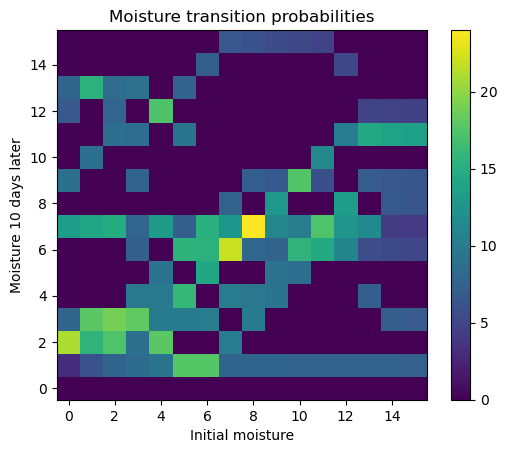

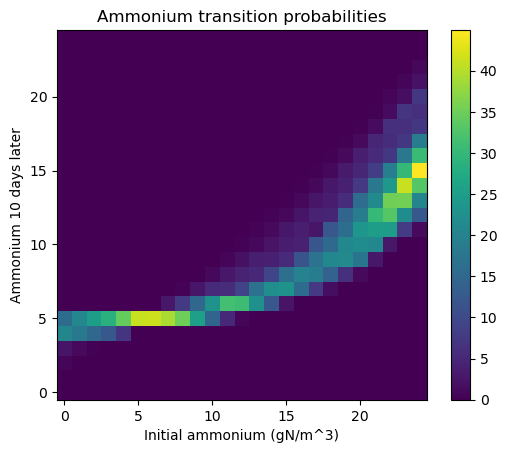

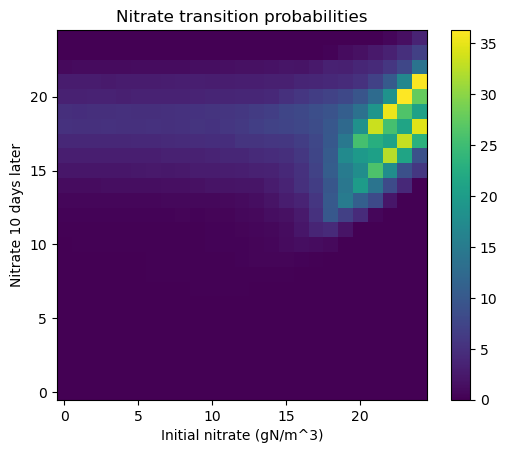

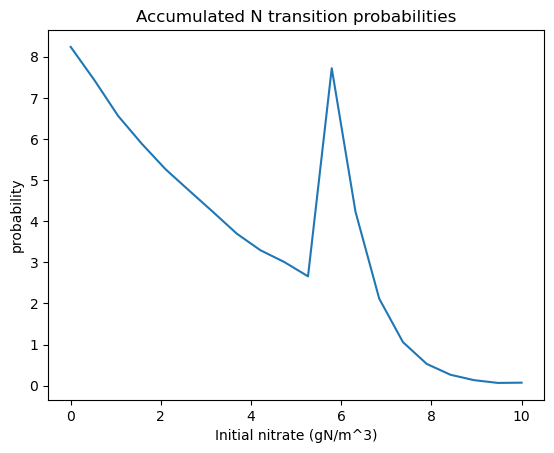

In [48]:
plt.figure()
plt.imshow(np.transpose(np.sum(transition_counts, (0, 1, 2, 4, 5, 7), np.float64)) / (NUM_TRIALS_PER_INITIAL_CONDITION * AMMONIUM_NUM_STEPS * NITRATE_NUM_STEPS * NUM_CONTROL_STEPS), origin="lower")
plt.colorbar()
plt.title("Moisture transition probabilities")
plt.xlabel("Initial moisture")
plt.ylabel("Moisture " + str(CONTROL_TIMESTEP_DAYS) + " days later")

plt.figure()
plt.imshow(np.transpose(np.sum(transition_counts, (0, 2, 3, 5, 6, 7), np.float64)) / (NUM_TRIALS_PER_INITIAL_CONDITION * MOISTURE_NUM_STEPS * NITRATE_NUM_STEPS * NUM_CONTROL_STEPS), origin="lower")
plt.colorbar()
plt.title("Ammonium transition probabilities")
plt.xlabel("Initial ammonium (gN/m^3)")
plt.ylabel("Ammonium " + str(CONTROL_TIMESTEP_DAYS) + " days later")

plt.figure()
plt.imshow(np.transpose(np.sum(transition_counts, (0, 1, 3, 4, 6, 7), np.float64)) / (NUM_TRIALS_PER_INITIAL_CONDITION * MOISTURE_NUM_STEPS * AMMONIUM_NUM_STEPS * NUM_CONTROL_STEPS), origin="lower")
plt.colorbar()
plt.title("Nitrate transition probabilities")
plt.xlabel("Initial nitrate (gN/m^3)")
plt.ylabel("Nitrate " + str(CONTROL_TIMESTEP_DAYS) + " days later")

plt.figure()
plt.plot(np.linspace(0, MAX_SINGLE_STEP_ACCUMULATED_N, SINGLE_STEP_ACCUMULATED_N_NUM_STEPS), np.sum(transition_counts, (0, 1, 2, 3, 4, 5, 6), np.float64) / (NUM_TRIALS_PER_INITIAL_CONDITION * MOISTURE_NUM_STEPS * AMMONIUM_NUM_STEPS * NITRATE_NUM_STEPS * NUM_CONTROL_STEPS))
# plt.colorbar()
plt.title("Accumulated N transition probabilities")
plt.xlabel("N accumulated over control period (gN/m^3)")
plt.ylabel("probability")

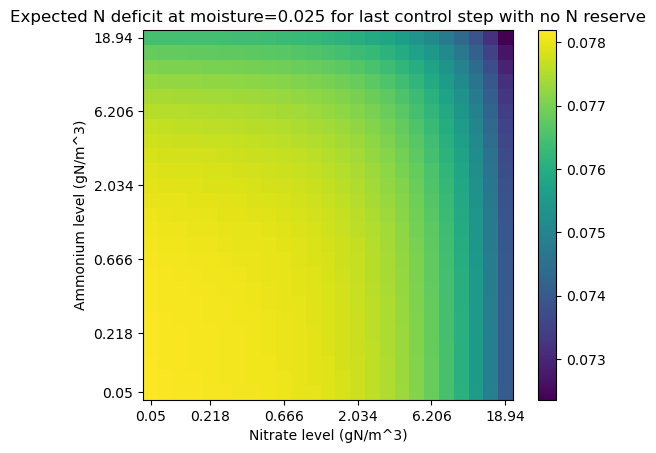

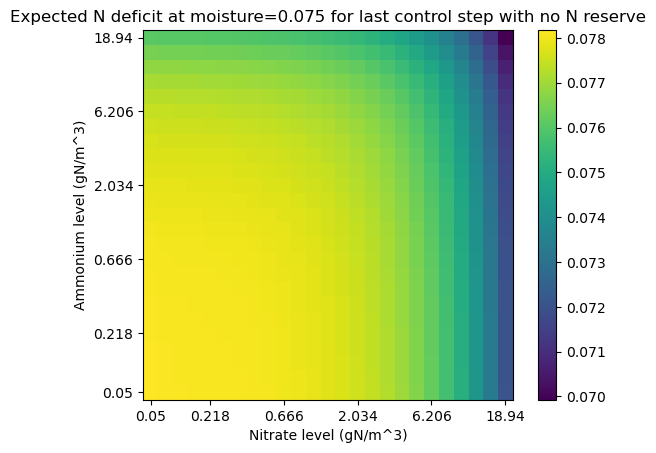

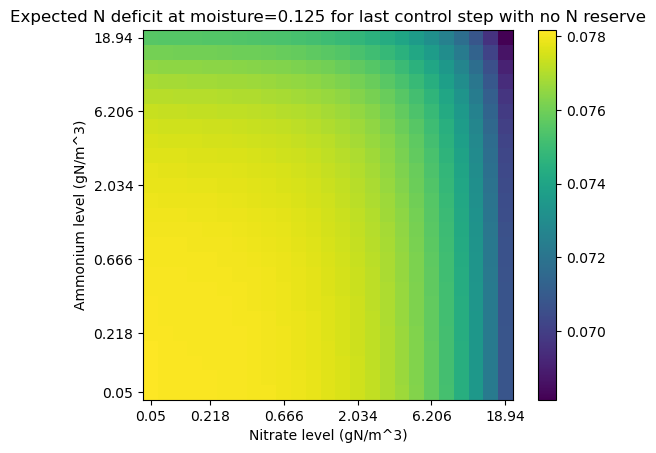

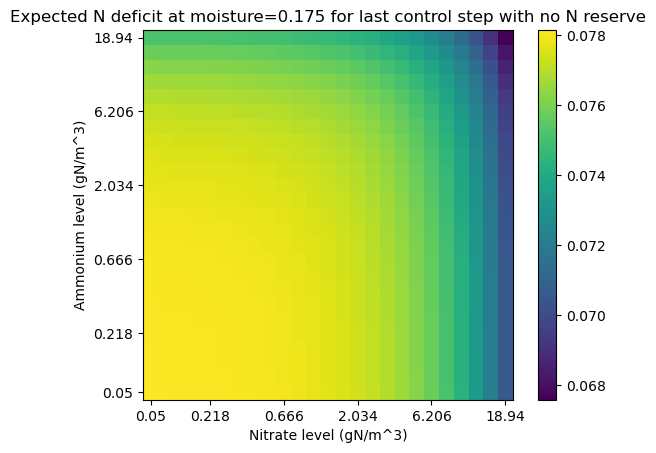

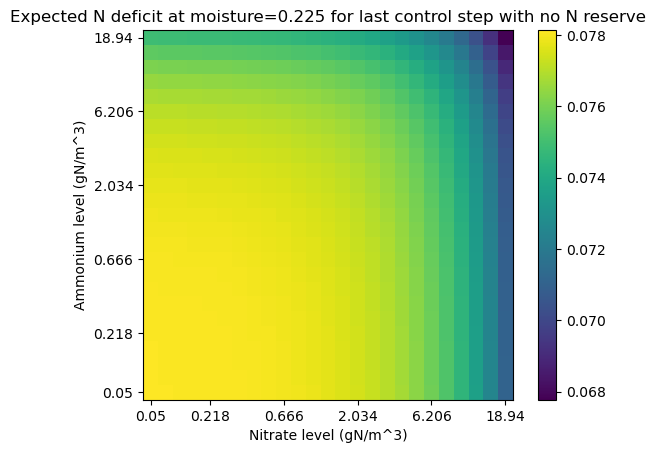

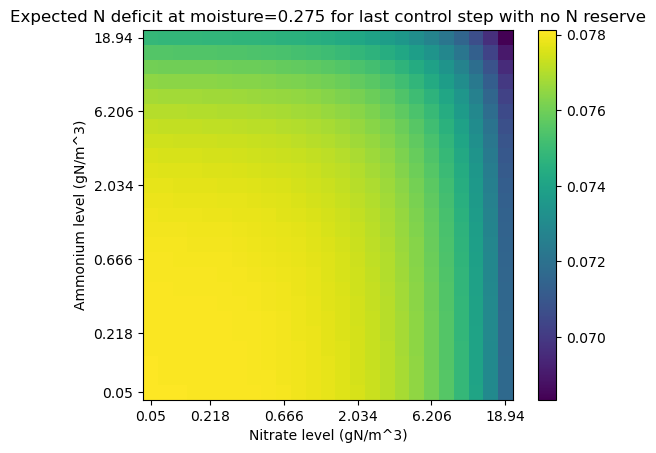

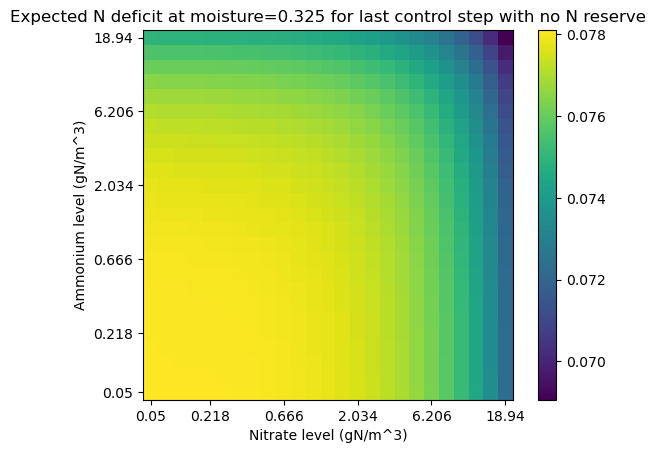

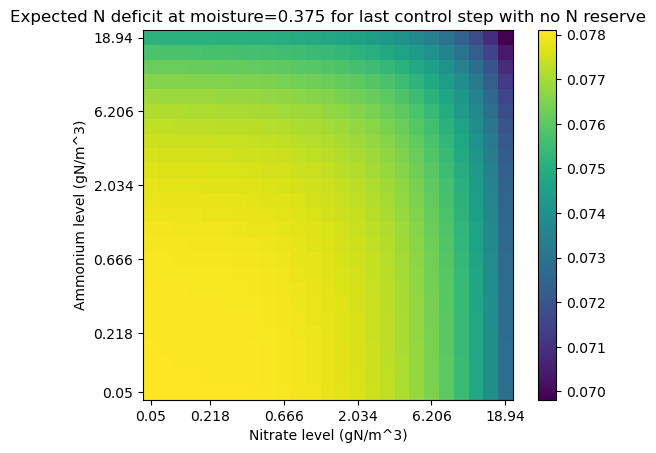

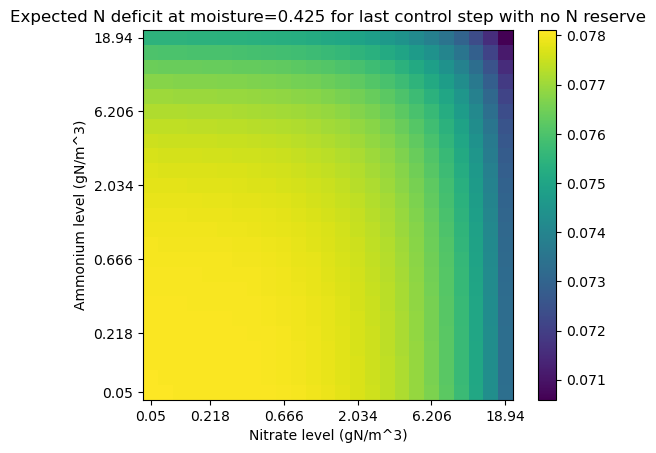

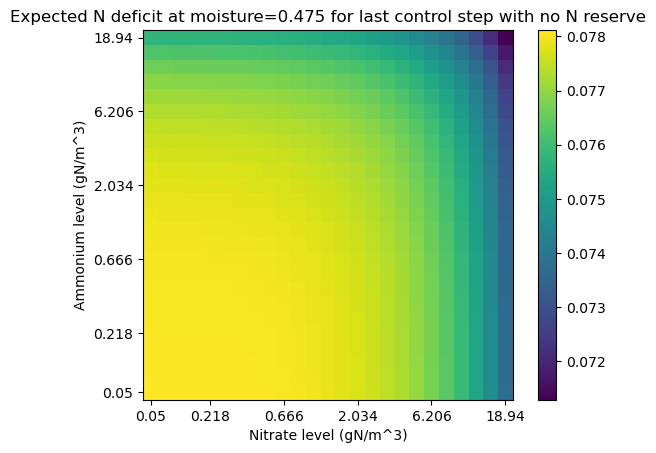

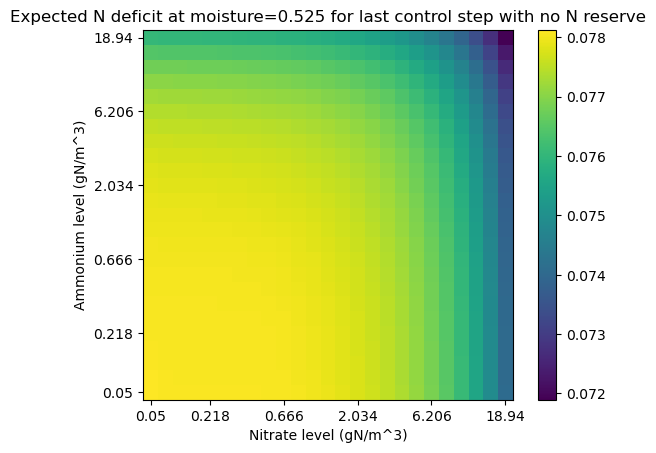

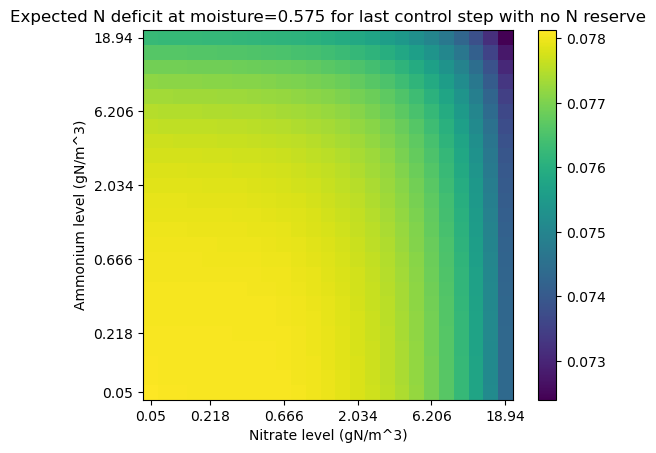

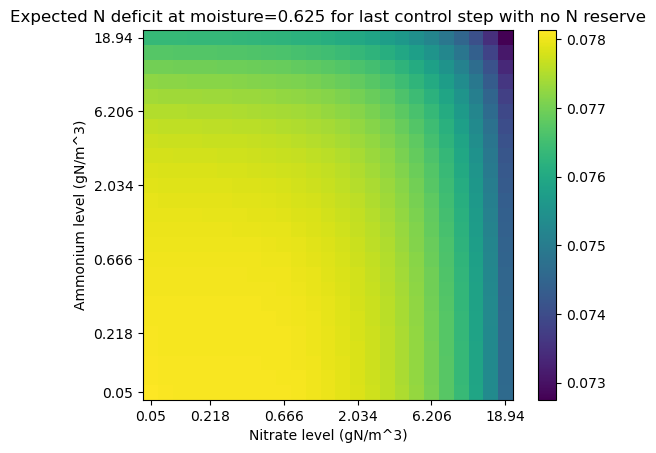

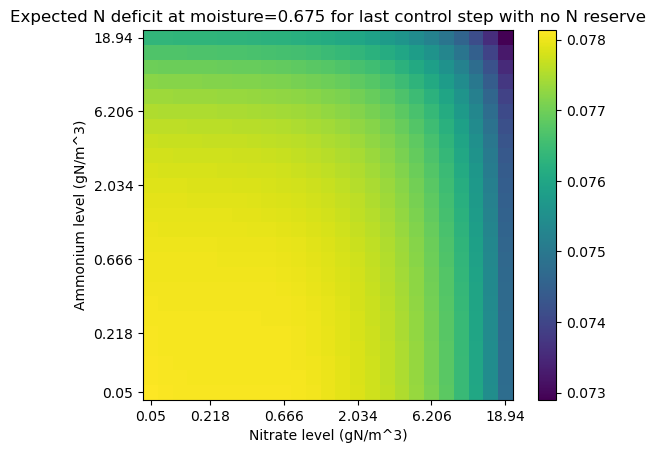

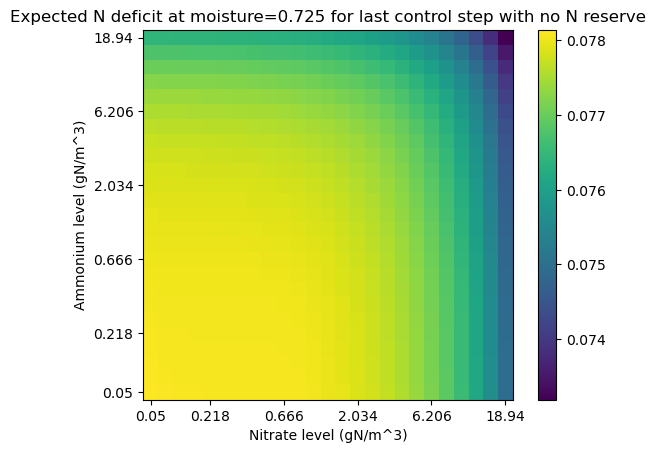

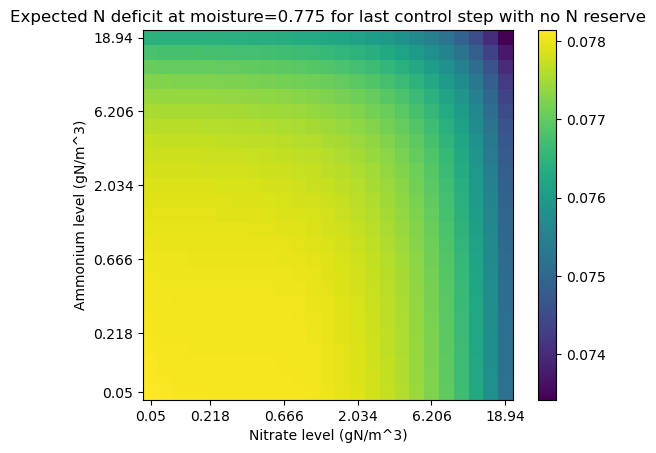

In [16]:
def moisture_idx_to_string(moisture_index: int):
    return str(round(indices_to_values(0, 0, moisture_index, 0)[2], 3))

for i in range(MOISTURE_NUM_STEPS):
    display_moisture_slice(expected_plant_N_deficit_cost_USD[-1, :, :, i, 0], "Expected N deficit at moisture=" + moisture_idx_to_string(i) + " for last control step with no N reserve")
# plt.close()

In [49]:
#TODO irrigation?
def find_optimal_cost_and_input(cost_to_go_from_cell_without_fertilizer: npt.NDArray[np.float64], output_cost_to_go: npt.NDArray[np.float64], output_ammonium_add_cells: npt.NDArray[np.uint8], output_nitrate_add_cells: npt.NDArray[np.uint8]):
    for initial_ammonium_index in range(AMMONIUM_NUM_STEPS):
        for initial_nitrate_index in range(NITRATE_NUM_STEPS):
            for initial_moisture_index in range(MOISTURE_NUM_STEPS):
                for initial_accumulated_N_index in range(ACCUMULATED_N_NUM_STEPS):
                    optimal_cost = cost_to_go_from_cell_without_fertilizer[initial_ammonium_index, initial_nitrate_index, initial_moisture_index, initial_accumulated_N_index]
                    optimal_ammonium_add = 0
                    optimal_nitrate_add = 0
                    pre_add_ammonium, pre_add_nitrate, _, _ = indices_to_values(initial_ammonium_index, initial_nitrate_index, 0, 0)
                    for post_add_ammonium_index in range(initial_ammonium_index, AMMONIUM_NUM_STEPS):
                        for post_add_nitrate_index in range(initial_nitrate_index, NITRATE_NUM_STEPS):
                            post_add_ammonium, post_add_nitrate, _, _ = indices_to_values(post_add_ammonium_index, post_add_nitrate_index, 0, 0)
                            added_n_cost = N_PRICE_USD_PER_G * (SOIL_DEPTH_MM / 1000.) * (post_add_ammonium - pre_add_ammonium + post_add_nitrate - pre_add_nitrate)
                            total_cost = cost_to_go_from_cell_without_fertilizer[post_add_ammonium_index, post_add_nitrate_index, initial_moisture_index, initial_accumulated_N_index] + added_n_cost
                            if total_cost < optimal_cost:
                                optimal_cost = total_cost
                                optimal_ammonium_add = post_add_ammonium_index - initial_ammonium_index
                                optimal_nitrate_add = post_add_nitrate_index - initial_nitrate_index
                    output_cost_to_go[initial_ammonium_index, initial_nitrate_index, initial_moisture_index, initial_accumulated_N_index] = optimal_cost
                    output_ammonium_add_cells[initial_ammonium_index, initial_nitrate_index, initial_moisture_index, initial_accumulated_N_index] = optimal_ammonium_add
                    output_nitrate_add_cells[initial_ammonium_index, initial_nitrate_index, initial_moisture_index, initial_accumulated_N_index] = optimal_nitrate_add

## Base Case

In [50]:
optimal_cost_to_go = np.ndarray([NUM_CONTROL_STEPS, AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS, MOISTURE_NUM_STEPS, ACCUMULATED_N_NUM_STEPS], np.float64)
optimal_ammonium_add_in_cells = np.ndarray([NUM_CONTROL_STEPS, AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS, MOISTURE_NUM_STEPS, ACCUMULATED_N_NUM_STEPS], np.uint8)
optimal_nitrate_add_in_cells = np.ndarray([NUM_CONTROL_STEPS, AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS, MOISTURE_NUM_STEPS, ACCUMULATED_N_NUM_STEPS], np.uint8)

In [51]:
find_optimal_cost_and_input(expected_plant_N_deficit_cost_USD[-1], optimal_cost_to_go[-1], optimal_ammonium_add_in_cells[-1], optimal_nitrate_add_in_cells[-1])

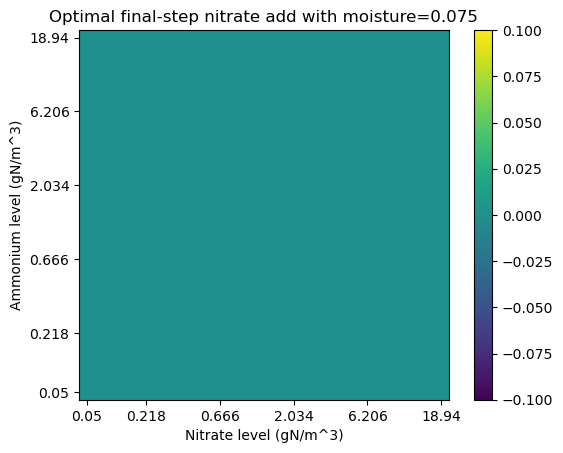

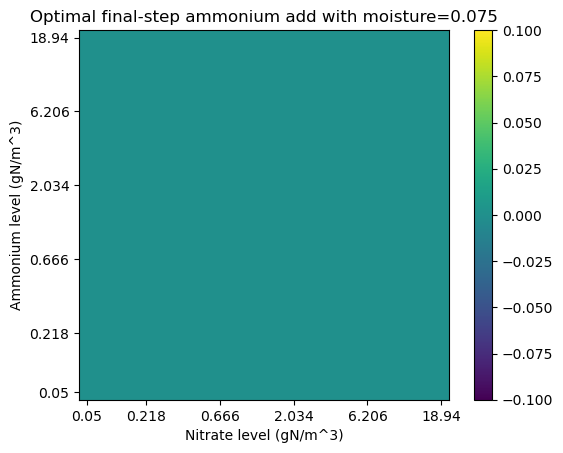

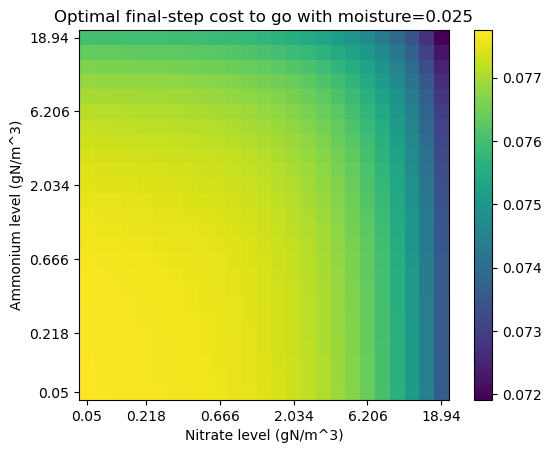

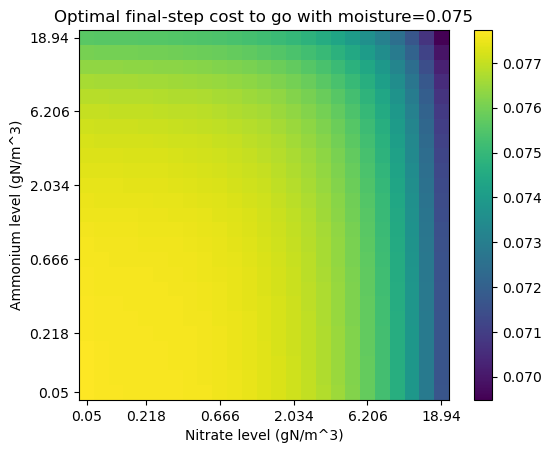

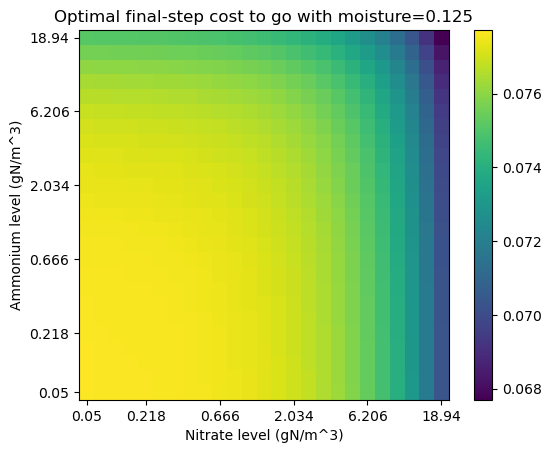

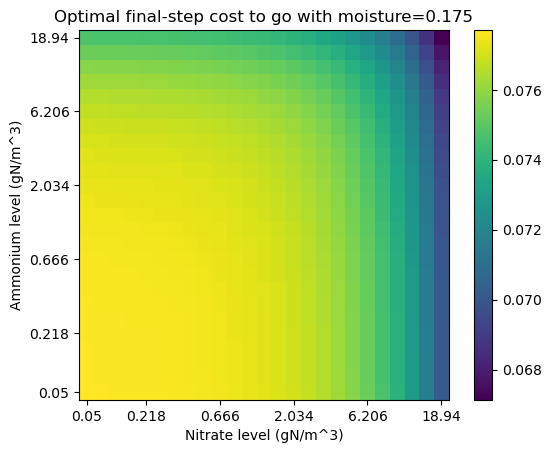

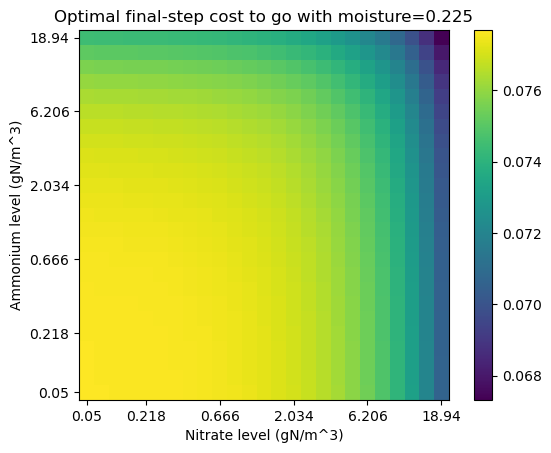

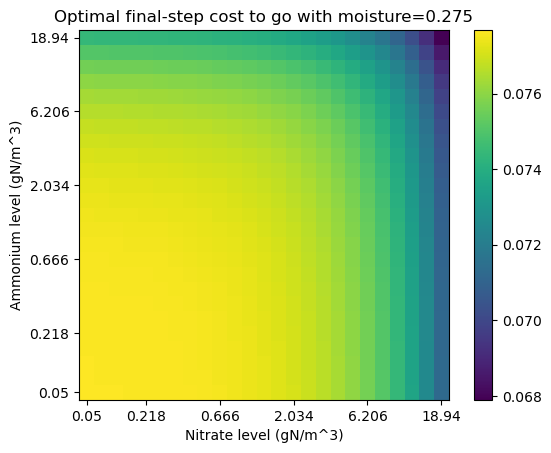

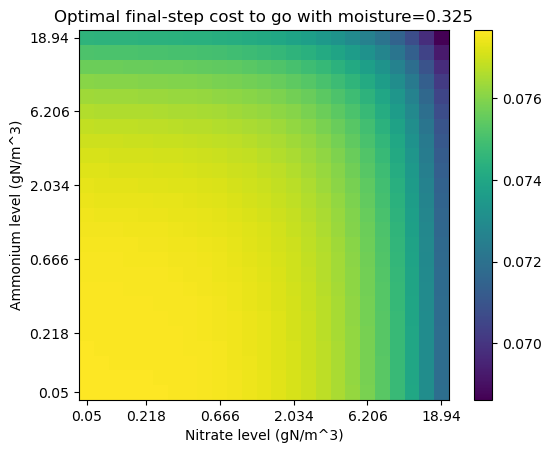

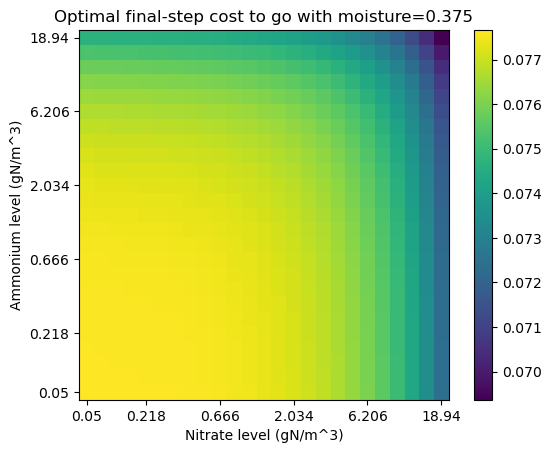

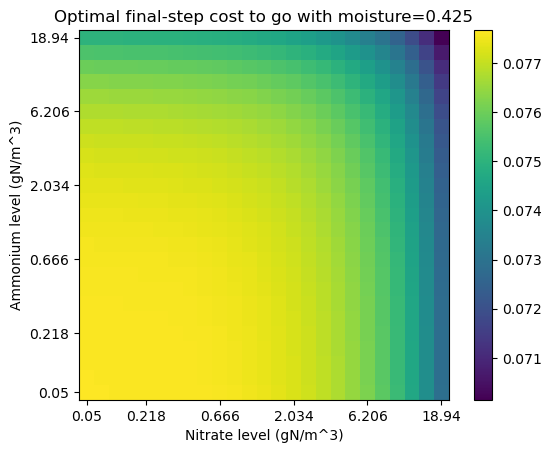

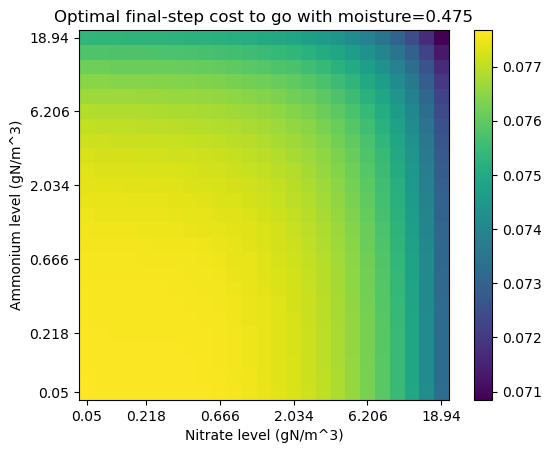

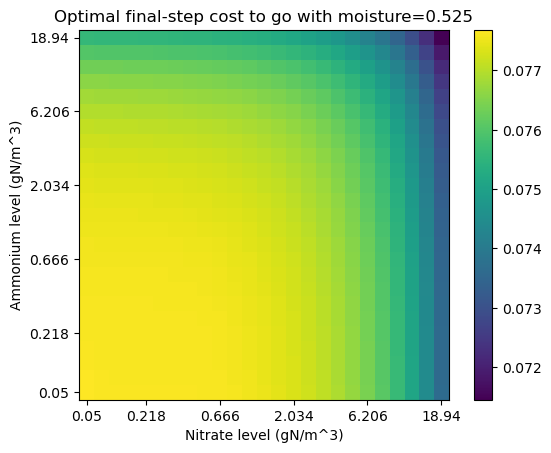

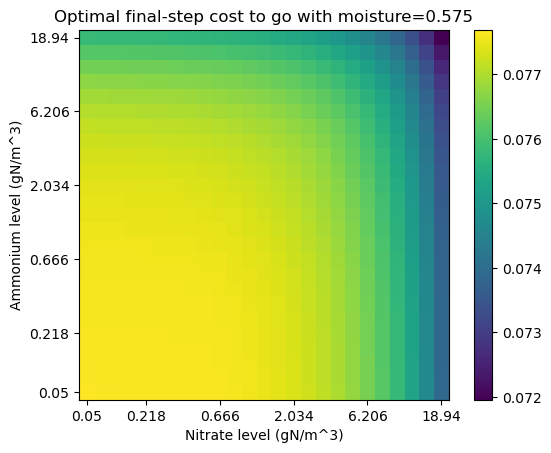

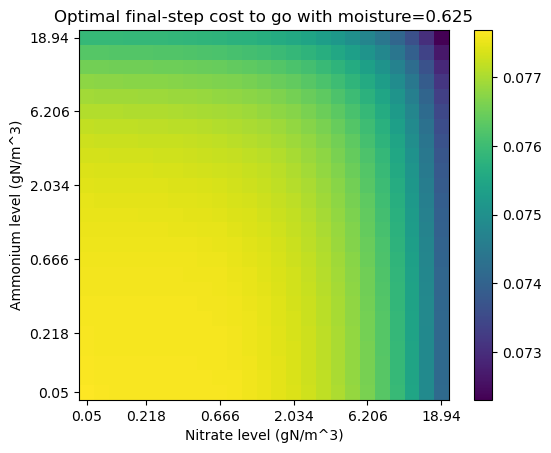

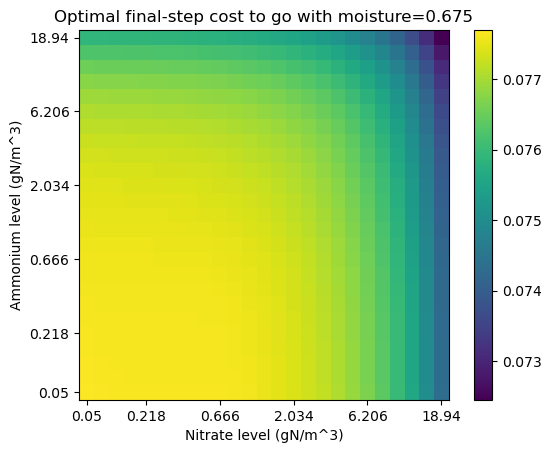

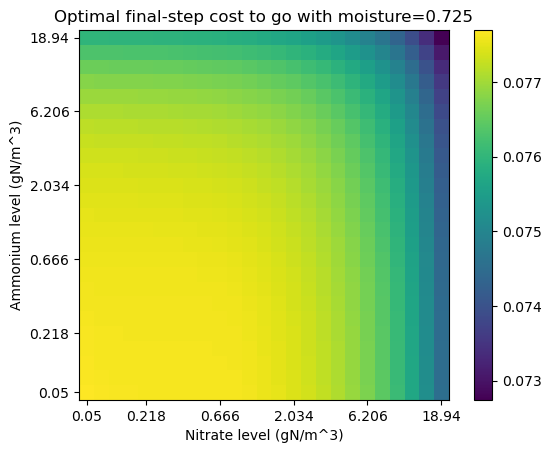

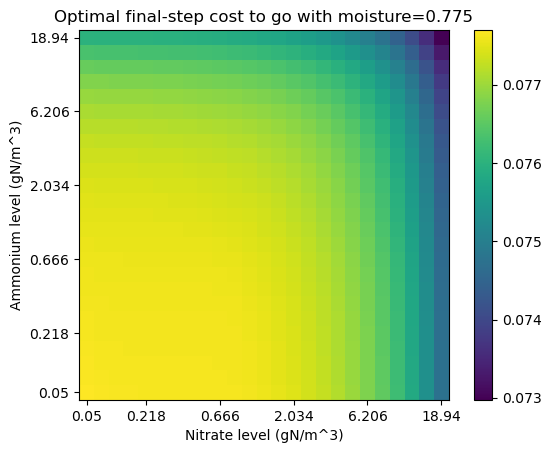

In [52]:
display_moisture_idx = 1
display_accumulated_N_idx = 1
display_moisture_slice(optimal_nitrate_add_in_cells[-1, :, :, display_moisture_idx, display_accumulated_N_idx], "Optimal final-step nitrate add with moisture=" + moisture_idx_to_string(display_moisture_idx))
display_moisture_slice(optimal_ammonium_add_in_cells[-1, :, :, display_moisture_idx, display_accumulated_N_idx], "Optimal final-step ammonium add with moisture=" + moisture_idx_to_string(display_moisture_idx))
for i in range(MOISTURE_NUM_STEPS):
    display_moisture_slice(optimal_cost_to_go[-1, :, :, i, display_accumulated_N_idx], "Optimal final-step cost to go with moisture=" + moisture_idx_to_string(i))

## Recurse

In [53]:
for i in reversed(range(NUM_CONTROL_STEPS - 1)):
    expected_cost_to_go_from_cell = np.ndarray([AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS, MOISTURE_NUM_STEPS, ACCUMULATED_N_NUM_STEPS], np.float64)
    for ammonium_index in range(AMMONIUM_NUM_STEPS):
        for nitrate_index in range(NITRATE_NUM_STEPS):
            for moisture_index in range(MOISTURE_NUM_STEPS):
                # this array is [ammonium, nitrate, moisture, change in accumulated N]
                transition_counts_from_zero_N = transition_counts[i+1, ammonium_index, nitrate_index, moisture_index]
                for accumulated_N_index in range(ACCUMULATED_N_NUM_STEPS):
                    accumulated_N_window_end = accumulated_N_index + SINGLE_STEP_ACCUMULATED_N_NUM_STEPS
                    if accumulated_N_window_end > ACCUMULATED_N_NUM_STEPS:
                        # sum up the transition counts that would go "out of range" and clip them to the top of the range
                        invalid_transition_counts = transition_counts_from_zero_N[:, :, :, -(accumulated_N_window_end - ACCUMULATED_N_NUM_STEPS):]
                        valid_transition_counts = transition_counts_from_zero_N[:, :, :, :-(accumulated_N_window_end - ACCUMULATED_N_NUM_STEPS)]
                        valid_transition_counts[:, :, :, -1] += np.sum(invalid_transition_counts, axis=3)
                        accumulated_N_window_end = ACCUMULATED_N_NUM_STEPS
                    else:
                        valid_transition_counts = transition_counts_from_zero_N
                    cropped_optimal_cost_to_go = optimal_cost_to_go[i+1, :, :, :, accumulated_N_index:accumulated_N_window_end]
                    expected_cost_to_go_from_cell[ammonium_index, nitrate_index, moisture_index, accumulated_N_index] = np.sum(valid_transition_counts * cropped_optimal_cost_to_go) / NUM_TRIALS_PER_INITIAL_CONDITION
                    # expected_cost_to_go_from_cell[ammonium_index, nitrate_index, moisture_index] = np.sum(transition_counts[ammonium_index, nitrate_index, moisture_index] * optimal_cost_to_go[-1, :, :, :])
    expected_cost_to_go_from_cell += expected_plant_N_deficit_cost_USD[i]
    # display_moisture_slice(expected_cost_to_go_from_cell[:, :, 1, 1], "Expected cost to go from cell at step " + str(i) + ", moisture=" + moisture_idx_to_string(1))
    find_optimal_cost_and_input(expected_cost_to_go_from_cell, optimal_cost_to_go[i], optimal_ammonium_add_in_cells[i], optimal_nitrate_add_in_cells[i])

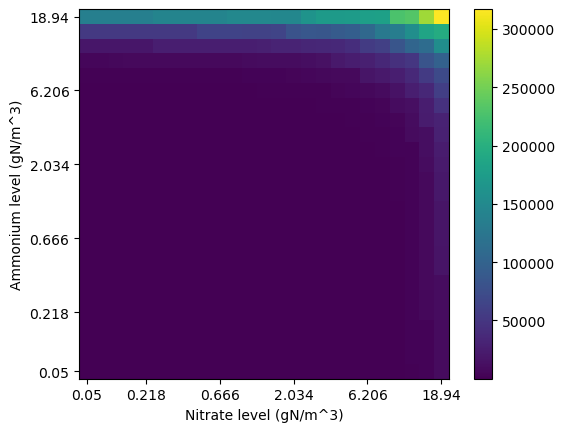

In [84]:
display_moisture_slice(optimal_cost_to_go[0, :, :, 4, 0], "")

In [69]:
def run_controller(control_period_days: int, num_control_periods: int, initial_soil_moisture: float, initial_ammonium_gN_per_m3: float, initial_nitrate_gN_per_m3: float, initial_litter_carbon_gC_per_m3: float = 1300.0, initial_litter_nitrogen_gN_per_m3: float = 38.2, initial_microbial_carbon_gC_per_m3: float = 50, initial_humus_carbon_gC_per_m3: float = 8500):
    rain_quantity_mm = generate_rain(control_period_days * num_control_periods)
    soil_moisture, _, _, transpiration_rate_mm_per_day, leakage_rate_mm_per_day, moisture_effect_on_decomposition_factor, moisture_effect_on_nitrification_factor = hydrology_model(initial_soil_moisture, rain_quantity_mm)

    _, _, biomass_carbon_g_per_m3, _, net_flux_to_mineralized_nitrogen_g_per_m3_per_day = soil_organic_model(initial_litter_carbon_gC_per_m3, initial_litter_nitrogen_gN_per_m3, initial_microbial_carbon_gC_per_m3, initial_humus_carbon_gC_per_m3, moisture_effect_on_decomposition_factor, np.zeros(control_period_days * num_control_periods), np.zeros(control_period_days * num_control_periods))

    ammonium_gN_per_m3 = initial_ammonium_gN_per_m3
    nitrate_gN_per_m3 = initial_nitrate_gN_per_m3
    accumulated_N_gN_per_m3 = 0
    ammonium_adds = np.ndarray(num_control_periods)
    nitrate_adds = np.ndarray(num_control_periods)
    total_ammonium_nitrogen_g_per_m3 = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_nitrate_nitrogen_g_per_m3 = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_plant_passive_uptake_of_ammonium_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_plant_passive_uptake_of_nitrate_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_plant_active_uptake_of_ammonium_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_plant_active_uptake_of_nitrate_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_nitrogen_deficit_cost = 0

    for i in range(num_control_periods):
        indices = values_to_indices(ammonium_gN_per_m3, nitrate_gN_per_m3, soil_moisture[i * control_period_days])
        accumulated_N_index = accumulated_N_value_to_index(accumulated_N_gN_per_m3)
        target_ammonium_index = optimal_ammonium_add_in_cells[i, *indices, accumulated_N_index] + indices[0]
        target_nitrate_index = optimal_nitrate_add_in_cells[i, *indices, accumulated_N_index] + indices[1]
        if target_ammonium_index == indices[0]:
            ammonium_adds[i] = 0
        else:
            ammonium_adds[i] = indices_to_values(target_ammonium_index, 0, 0, 0)[0] - ammonium_gN_per_m3
        if target_nitrate_index == indices[1]:
            nitrate_adds[i] = 0
        else:
            nitrate_adds[i] = indices_to_values(0, target_nitrate_index, 0, 0)[1] - nitrate_gN_per_m3
        display_moisture_slice(optimal_ammonium_add_in_cells[i, :, :, indices[2], accumulated_N_index], "Optimal ammonium add for step " + str(i) + " with moisture " + str(round(soil_moisture[i * control_period_days], 2)), point_nitrate=nitrate_gN_per_m3, point_ammonium=ammonium_gN_per_m3)
        display_moisture_slice(optimal_nitrate_add_in_cells[i, :, :, indices[2], accumulated_N_index], "Optimal nitrate add for step " + str(i) + " with moisture " + str(round(soil_moisture[i * control_period_days], 2)), point_nitrate=nitrate_gN_per_m3, point_ammonium=ammonium_gN_per_m3)
        ammonium_gN_per_m3 = ammonium_gN_per_m3 + ammonium_adds[i]
        nitrate_gN_per_m3 = nitrate_gN_per_m3 + nitrate_adds[i]

        start_day = i * control_period_days
        end_day = (i + 1) * control_period_days

        ammonium_nitrogen_g_per_m3, nitrate_nitrogen_g_per_m3, ammonium_leaching_gN_per_m3_per_day, nitrate_leaching_gN_per_m3_per_day, plant_passive_uptake_of_ammonium_gN_per_m3_per_day, plant_passive_uptake_of_nitrate_gN_per_m3_per_day, plant_active_uptake_of_ammonium_gN_per_m3_per_day, plant_active_uptake_of_nitrate_gN_per_m3_per_day, assumptions_violation, _ = inorganic_nitrogen_model(ammonium_gN_per_m3, nitrate_gN_per_m3, float(i * control_period_days), leakage_rate_mm_per_day[start_day : end_day], transpiration_rate_mm_per_day[start_day : end_day], soil_moisture[start_day : end_day], net_flux_to_mineralized_nitrogen_g_per_m3_per_day[start_day : end_day], biomass_carbon_g_per_m3[start_day : end_day], output_dt_days=INORGANIC_N_MODEL_DT_DAYS)

        # total_nitrogen_deficit_cost += nitrogen_deficit_cost(plant_passive_uptake_of_ammonium_gN_per_m3_per_day, plant_active_uptake_of_ammonium_gN_per_m3_per_day, PLANT_AMMONIUM_DEMAND_GRAMS_N_PER_M3_PER_DAY, INORGANIC_N_MODEL_DT_DAYS) + nitrogen_deficit_cost(plant_passive_uptake_of_nitrate_gN_per_m3_per_day, plant_active_uptake_of_nitrate_gN_per_m3_per_day, PLANT_NITRATE_DEMAND_GRAMS_N_PER_M3_PER_DAY, INORGANIC_N_MODEL_DT_DAYS)
        total_ammonium_nitrogen_g_per_m3[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = ammonium_nitrogen_g_per_m3
        total_nitrate_nitrogen_g_per_m3[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = nitrate_nitrogen_g_per_m3
        total_plant_passive_uptake_of_ammonium_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = plant_passive_uptake_of_ammonium_gN_per_m3_per_day
        total_plant_passive_uptake_of_nitrate_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = plant_passive_uptake_of_nitrate_gN_per_m3_per_day
        total_plant_active_uptake_of_ammonium_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = plant_active_uptake_of_ammonium_gN_per_m3_per_day
        total_plant_active_uptake_of_nitrate_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = plant_active_uptake_of_nitrate_gN_per_m3_per_day
        combined_N_uptake = plant_passive_uptake_of_ammonium_gN_per_m3_per_day + plant_passive_uptake_of_nitrate_gN_per_m3_per_day + plant_active_uptake_of_ammonium_gN_per_m3_per_day + plant_active_uptake_of_nitrate_gN_per_m3_per_day
        total_nitrogen_deficit_cost += nitrogen_deficit_cost(combined_N_uptake, accumulated_N_gN_per_m3, INORGANIC_N_MODEL_DT_DAYS)
        accumulated_N_gN_per_m3 = accumulated_N_index + np.sum(combined_N_uptake) * INORGANIC_N_MODEL_DT_DAYS

        ammonium_gN_per_m3 = ammonium_nitrogen_g_per_m3[-1]
        nitrate_gN_per_m3 = nitrate_nitrogen_g_per_m3[-1]

    return total_nitrogen_deficit_cost, total_ammonium_nitrogen_g_per_m3, total_nitrate_nitrogen_g_per_m3, total_plant_passive_uptake_of_ammonium_gN_per_m3_per_day, total_plant_passive_uptake_of_nitrate_gN_per_m3_per_day, total_plant_active_uptake_of_ammonium_gN_per_m3_per_day, total_plant_active_uptake_of_nitrate_gN_per_m3_per_day, ammonium_adds, nitrate_adds, soil_moisture, transpiration_rate_mm_per_day

np.float64(0.3131885601959686)

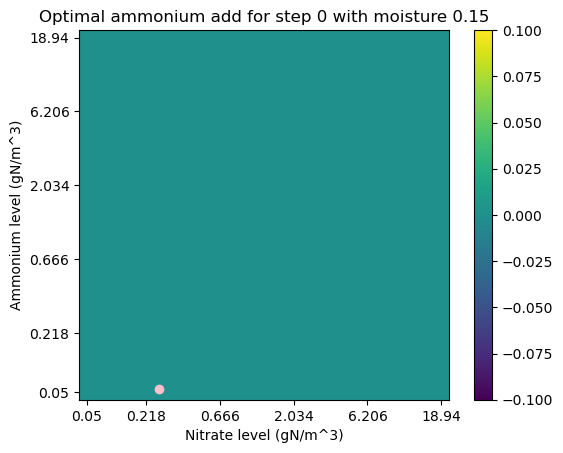

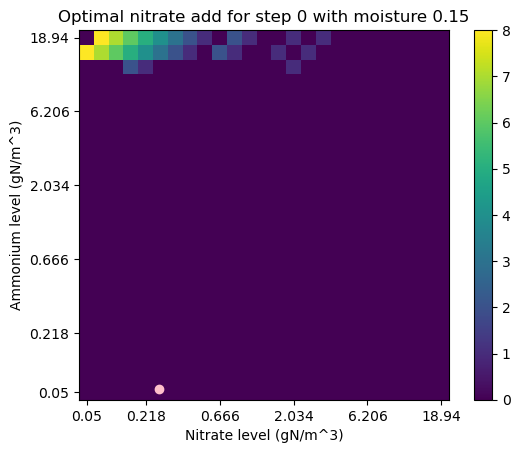

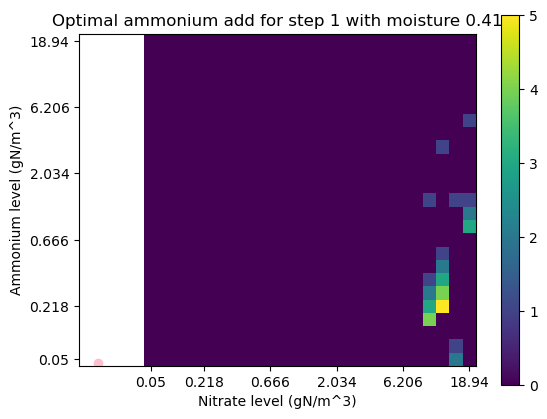

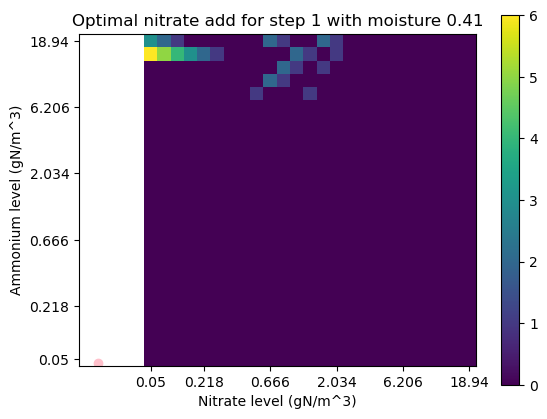

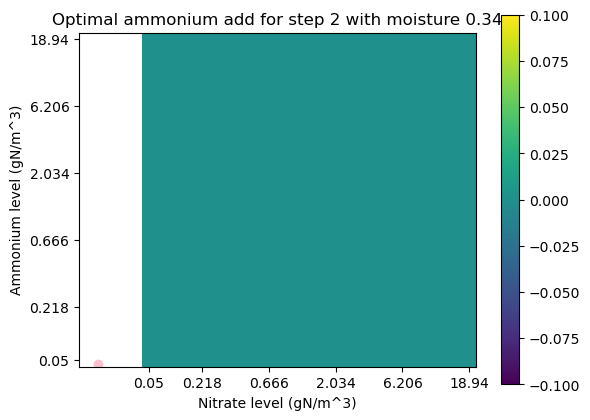

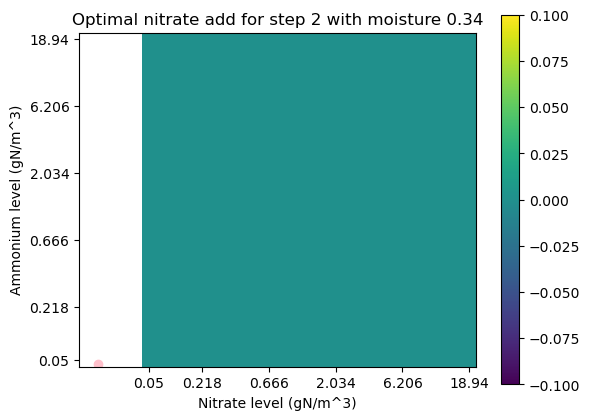

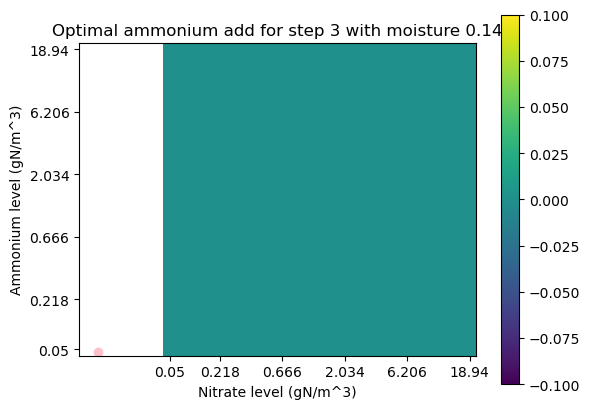

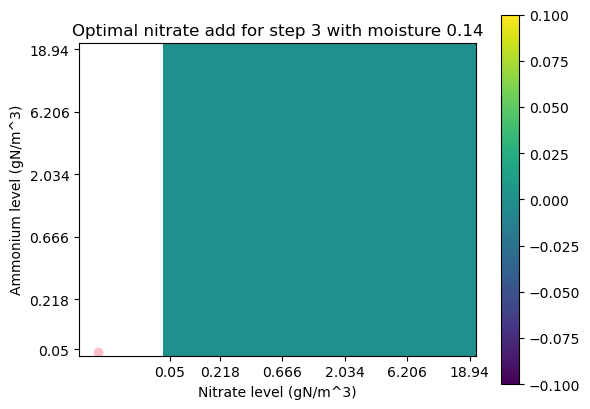

In [70]:
cost, ammonium, nitrate, ammonium_passive_uptake, nitrate_passive_uptake, ammonium_active_uptake, nitrate_active_uptake, added_ammonium, added_nitrate, experiment_soil_moisture, experiment_transpiration = run_controller(CONTROL_TIMESTEP_DAYS, NUM_CONTROL_STEPS, 0.15, 0.105, 0.3)
cost

In [71]:
added_ammonium

array([0., 0., 0., 0.])

In [72]:
added_nitrate

array([0., 0., 0., 0.])

In [73]:
minimum_nitrate_add = []
for i in range(NUM_CONTROL_STEPS):
    control_time_nitrate_idx = values_to_indices(0.1, nitrate[i * int(CONTROL_TIMESTEP_DAYS / INORGANIC_N_MODEL_DT_DAYS)], 0)[1]
    minimum_nitrate_add.append(indices_to_values(0, control_time_nitrate_idx + 1, 0, 0)[1] - indices_to_values(0, control_time_nitrate_idx, 0, 0)[1])
minimum_nitrate_add

[np.float64(0.06823937919616058),
 np.float64(0.06180339887498949),
 np.float64(0.06180339887498949),
 np.float64(0.06180339887498949)]

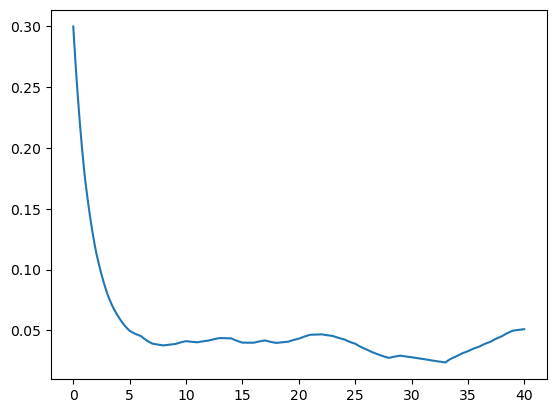

In [74]:
plt.plot(np.arange(len(nitrate_passive_uptake)) * INORGANIC_N_MODEL_DT_DAYS, nitrate)

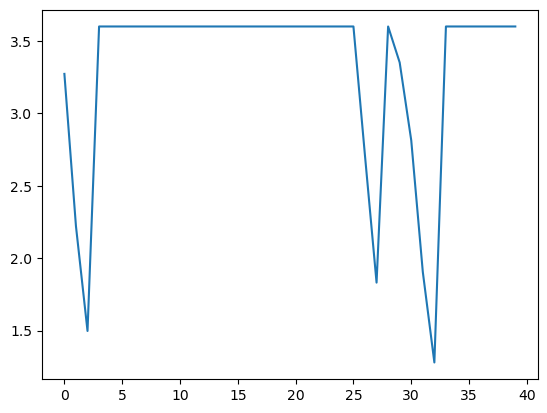

In [75]:
plt.plot(range(len(experiment_transpiration)), experiment_transpiration)

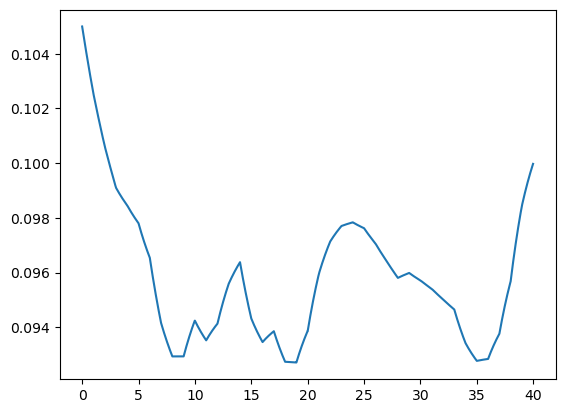

In [76]:
plt.plot(np.arange(len(ammonium)) * INORGANIC_N_MODEL_DT_DAYS, ammonium)

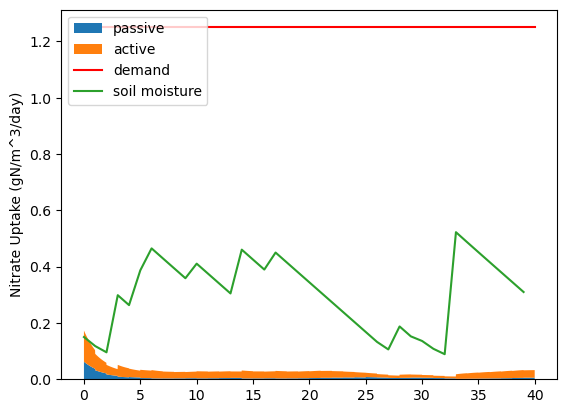

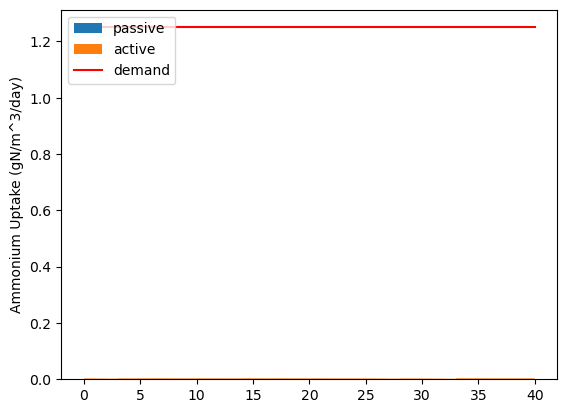

In [77]:
plt.figure()
plt.ylabel("Nitrate Uptake (gN/m^3/day)")
plt.stackplot(np.arange(len(nitrate_passive_uptake)) * INORGANIC_N_MODEL_DT_DAYS, nitrate_passive_uptake, nitrate_active_uptake, labels=["passive", "active"])
plt.plot(np.linspace(0, NUM_CONTROL_STEPS * CONTROL_TIMESTEP_DAYS), day_to_plant_N_demand_gN_per_m3_per_day(np.linspace(0, NUM_CONTROL_STEPS * CONTROL_TIMESTEP_DAYS)) / 2.0, color="red", label="demand")
plt.plot(range(len(experiment_soil_moisture)), experiment_soil_moisture, label="soil moisture")
plt.legend(loc="upper left")
plt.figure()
plt.ylabel("Ammonium Uptake (gN/m^3/day)")
plt.stackplot(np.arange(len(ammonium_active_uptake)) * INORGANIC_N_MODEL_DT_DAYS, ammonium_passive_uptake, ammonium_active_uptake, labels=["passive", "active"])
plt.plot(np.linspace(0, NUM_CONTROL_STEPS * CONTROL_TIMESTEP_DAYS), day_to_plant_N_demand_gN_per_m3_per_day(np.linspace(0, NUM_CONTROL_STEPS * CONTROL_TIMESTEP_DAYS)) / 2.0, color="red", label="demand")
plt.legend(loc="upper left")

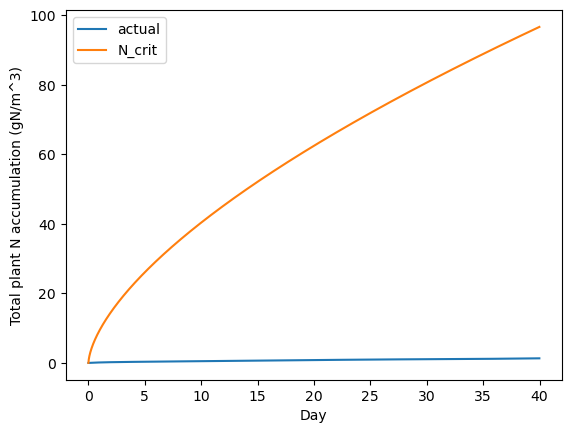

In [78]:
total_uptake = np.cumsum((ammonium_passive_uptake + nitrate_passive_uptake + ammonium_active_uptake + nitrate_active_uptake) * INORGANIC_N_MODEL_DT_DAYS)
plt.figure()
x_series = np.arange(len(total_uptake)) * INORGANIC_N_MODEL_DT_DAYS
plt.plot(x_series, total_uptake, label="actual")
plt.ylabel("Total plant N accumulation (gN/m^3)")
plt.xlabel("Day")
plt.plot(x_series, biomass_g_per_m2_to_critical_nitrogen_gN_per_m2(day_to_biomass_g_per_m2(x_series)) / (SOIL_DEPTH_MM / 1000.), label="N_crit")
plt.legend(loc="upper left")

In [79]:
import pickle

with open('transition_counts.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(transition_counts, f, pickle.HIGHEST_PROTOCOL)
with open('expected_plant_N_deficit.pickle', 'wb') as f:
    pickle.dump(expected_plant_N_deficit_cost_USD, f, pickle.HIGHEST_PROTOCOL)

In [80]:
# import pickle
# with open('transition_counts_1000.pickle', 'rb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     transition_counts = pickle.load(f)
# with open('expected_plant_N_deficit.pickle', 'rb') as f:
#     expected_plant_N_deficit = pickle.load(f)